# Lab Two: Classification

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our data set consists of over 5 million rows of flight information in the domestic United States for the year of 2015. In order to optimize our modeling time, we have narrowed the scope of our classification tasks to the Dallas area only (Dallas Love Field and DFW airports). 

The goal for this project is to build two classification models to predict the following for the DFW area:
1. Whether or not the flight was cancelled (our binary classification model)
2. For delayed flights, how long was the departure delay (in terms of groups - our multi-class classification model).

Because the scope of our two classification models is different, we will create two data sets for each modelling task.

# 1. Data Preparation Part 1

- **[10 points]** Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [220]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#from datetime import datetime
import altair as alt
import datetime

# Machine learning
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [97]:
import warnings
warnings.filterwarnings('ignore')

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. Later on will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)




# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')
# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

## 1.1 Subset to DFW area

This step will reduce our data down to flights departing from Dallas area airports only.

In [98]:
df = df[(df.ORIGIN_AIRPORT == 'DFW') | (df.ORIGIN_AIRPORT == 'DAL')]
df.shape

(299250, 32)

In reducing our flights to only those that originated from DFW or Love Field, we moved from 5,819,079 flights to 299,259. One of the things that we learned from Lab 1 and the Mini Project is that modeling on the full flight data set was often too computationally intensive for all of our machines. Subsetting the data not only allows us to focus on relevant airports for those of us that are local to the metroplex, but also produce a more computationally-friendly data set.

In [99]:
# Check airline counts
print(df['AIRLINE'].value_counts())
# Check cancellations
print('\n')
print(df['CANCELLED'].value_counts())

American Airlines Inc.          134270
American Eagle Airlines Inc.     53603
Southwest Airlines Co.           52670
Atlantic Southeast Airlines      24649
Spirit Air Lines                  8519
Delta Air Lines Inc.              6532
Virgin America                    5050
Skywest Airlines Inc.             4136
United Air Lines Inc.             3505
US Airways Inc.                   3082
Alaska Airlines Inc.              1348
Frontier Airlines Inc.            1288
JetBlue Airways                    598
Name: AIRLINE, dtype: int64


0    292146
1      7104
Name: CANCELLED, dtype: int64


American Airlines is the max class (as expected), but we do still have a decent sample size for some of the smaller airlines. We have reduced the data down from 5 million+ rows to 598,535 rows which is a much more manageable size (although still a lot of data!).

Additionally, this is an unbalanced data set for one of our desired classification items, which is whether or not the flight is cancelled. When we are doing our test and training splits, we can either under or oversample our data, or choose a different cut-off value to optimize sensitivity and specificity in this binary classification. For the purposes of this lab, we will test model performance on the original data, undersampled data, and a combination of SMOTE and undersampled data. 

## 1.2 Create New Variables

The data contains several timestamp and continuous variables that add additional complexity, and several models cannot run with timstamp data. In order to simplify the data, we created buckets to analyze similar attributes together.

We first convert `SCHEDULED_DEPARTURE`, `DEPARTURE_TIME`, `ARRIVAL_TIME`, and `SCHEDULED_ARRIVAL` into buckets based on their timestamp.

    Overnight: 12:00am - 5:59am
    Morning: 6:00am - 11:59am
    Afternoon: 12:00pm - 5:59pm
    Evening: 6:00pm - 11:59pm

[Flight] `DISTANCE` is also divided into buckets.

    Short: 1-99 miles
    Medium: 100-999 miles
    Long: 1,000+ miles

In [100]:
# Convert times into buckets for morning, afternoon, and evening as most models cannot handle timestamps.
cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 600, 1200, 1800, 2359]

df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'].astype(float), 
                                    bins=cut_bins, 
                                    labels=cut_labels, 
                                    include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'].astype(float), 
                                     bins=cut_bins, 
                                     labels=cut_labels, 
                                     include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'].astype(float), 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)
df['ACTUAL_ARRIVAL_TIME'] = pd.cut(df['ARRIVAL_TIME'].astype(float), 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)

# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Look at our data with the buckets
pd.set_option('display.max_columns', None)
#df.head()

In [101]:
# Check how many of each bin we have
sched_depart = df['SCHED_DEPARTURE_TIME'].value_counts()
actual_depart = df['ACTUAL_DEPARTURE_TIME'].value_counts()
sched_arrival = df['SCHED_ARRIVAL_TIME'].value_counts()
actual_arrival = df['ACTUAL_ARRIVAL_TIME'].value_counts()
dist_bucket = df['DISTANCE_BUCKET'].value_counts()

print(sched_depart, '\n\n', actual_depart, '\n\n', sched_arrival, '\n\n', actual_arrival, '\n\n', dist_bucket)

afternoon    111632
morning      106543
evening       76617
overnight      4458
Name: SCHED_DEPARTURE_TIME, dtype: int64 

 afternoon    109057
morning      100388
evening       78415
overnight      4660
Name: ACTUAL_DEPARTURE_TIME, dtype: int64 

 afternoon    113185
evening      108932
morning       73270
overnight      3863
Name: SCHED_ARRIVAL_TIME, dtype: int64 

 afternoon    108247
evening      105503
morning       70146
overnight      7886
Name: ACTUAL_ARRIVAL_TIME, dtype: int64 

 Medium    210290
Long       87349
Short       1611
Name: DISTANCE_BUCKET, dtype: int64


In [102]:
# Create a new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df['DELAYED'] = df.ARRIVAL_DELAY.apply(get_delay)
#df.head()

Last, we create a new binary variable based off of `ARRIVAL_DELAY`. 

## 1.3 Adding Weather Data

### 1.3.1 Process Dates & Time

We want to join our flight data to weather data for additional features. First, we create a date column for joining up to Dallas weather information.

In [103]:
# Source: https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month
df['FLIGHT_DATE'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(df.YEAR, df.MONTH, df.DAY)])

Next we'll write a function to convert the numeric time strings into datetime format.

In [104]:
# Creating a function to change the way of representation of time in the column
def fun_format_time(hours):
        if hours == 2400:
            hours = 0
        else:
            hours = "{0:04d}".format(int(hours))
            Hourmin = datetime.time(int(hours[0:2]), int(hours[2:4]))
            return Hourmin

In [105]:
# Define the time columns
cols = ["SCHEDULED_DEPARTURE", 
        "DEPARTURE_TIME", 
        "SCHEDULED_ARRIVAL", 
        #"SCHEDULED_TIME",
        "ARRIVAL_TIME",
        "WHEELS_ON",
        "WHEELS_OFF"]

In [106]:
# Look at the data prior to conversion
df[cols].head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,WHEELS_ON,WHEELS_OFF
70,0515,0703,0856,1038,1031,0718
124,0545,0603,0849,0847,0842,0616
203,0600,0606,0925,0928,0924,0624
209,0600,0554,1010,1005,1001,0627
310,0600,NaN,0718,NaN,NaN,NaN


We noticed that record 310 has NaN where times should be. This is an example of a cancelled flight. We'll need to have our function exclude those when it processes the columns. 

In [107]:
# Convert times to float in order to correctly process them through the function
df[cols] = df[cols].astype(float)

In [108]:
# Run times through the new function
# Code adapted from: https://stackoverflow.com/questions/35232705/how-to-test-for-nans-in-an-apply-function-in-pandas
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['DEPARTURE_TIME']      = df['DEPARTURE_TIME'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['SCHEDULED_ARRIVAL']   = df['SCHEDULED_ARRIVAL'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['ARRIVAL_TIME']        = df['ARRIVAL_TIME'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
# df['SCHEDULED_TIME']      = df['SCHEDULED_TIME'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['WHEELS_ON']           = df['WHEELS_ON'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)
df['WHEELS_OFF']          = df['WHEELS_OFF'].apply(lambda x: fun_format_time(x) if pd.notnull(x) else x)

In [109]:
df[cols].head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,WHEELS_ON,WHEELS_OFF
70,05:15:00,07:03:00,08:56:00,10:38:00,10:31:00,07:18:00
124,05:45:00,06:03:00,08:49:00,08:47:00,08:42:00,06:16:00
203,06:00:00,06:06:00,09:25:00,09:28:00,09:24:00,06:24:00
209,06:00:00,05:54:00,10:10:00,10:05:00,10:01:00,06:27:00
310,06:00:00,NaN,07:18:00,NaN,NaN,NaN


Now that we have the times correctly formatted, let's combine the `FLIGHT_DATE` feature with `SCHEDULED_DEPARTURE` and `SCHEDULED_ARRIVAL` to create a complete datetime feature for each.

In [110]:
# Source: https://stackoverflow.com/questions/17978092/combine-date-and-time-columns-using-python-pandas

# Combine date & time for departure and arrival
df['SCHEDULED_DEPARTURE_DT'] = pd.to_datetime(df['FLIGHT_DATE'].astype(str) + ' ' + df['SCHEDULED_DEPARTURE'].astype(str))
df['SCHEDULED_ARRIVAL_DT']   = pd.to_datetime(df['FLIGHT_DATE'].astype(str) + ' ' + df['SCHEDULED_ARRIVAL'].astype(str))

In [111]:
# Look at the columns to make sure everything looks correct
#df.head()

### 1.3.2 Append Dallas-Area Weather

We download historical weather data for the DFW area from [Open Weather](https://openweathermap.org) and will append it to our data set in order to use it with our models.

In [112]:
# Read in the data
import datetime
weather = pd.read_csv('../Data/dfw_weather.csv')
weather['dt_iso'] = weather['dt_iso'].astype(str)

In [113]:
# Remove "+0000 UTC"
weather['dt_iso_update'] = weather['dt_iso'].str.split('+').str[0]

In [114]:
# Look at the data
weather.info()
weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68238 entries, 0 to 68237
Data columns (total 26 columns):
dt                     68238 non-null int64
dt_iso                 68238 non-null object
timezone               68238 non-null int64
city_name              68238 non-null object
lat                    68238 non-null float64
lon                    68238 non-null float64
temp                   68238 non-null float64
feels_like             68238 non-null float64
temp_min               68238 non-null float64
temp_max               68238 non-null float64
pressure               68238 non-null int64
sea_level              0 non-null float64
grnd_level             0 non-null float64
humidity               68238 non-null int64
wind_speed             68238 non-null float64
wind_deg               68238 non-null int64
rain_1h                7593 non-null float64
rain_3h                1261 non-null float64
snow_1h                247 non-null float64
snow_3h                43 non-null float6

,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,dt_iso_update
0,1388534400,2014-01-01 00:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,46.98,35.71,42.80,50.00,1025,NaN,NaN,37,11.50,160,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n,2014-01-01 00:00:00
1,1388538000,2014-01-01 01:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,44.51,32.25,40.64,48.20,1024,NaN,NaN,46,13.80,140,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n,2014-01-01 01:00:00
2,1388541600,2014-01-01 02:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,42.76,32.70,39.00,46.40,1024,NaN,NaN,42,9.22,160,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n,2014-01-01 02:00:00
3,1388545200,2014-01-01 03:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,42.58,31.23,37.40,46.94,1024,NaN,NaN,42,11.50,170,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n,2014-01-01 03:00:00
4,1388548800,2014-01-01 04:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,41.85,29.91,37.04,44.96,1023,NaN,NaN,45,12.66,160,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n,2014-01-01 04:00:00


In [115]:
# Convert new column to a datetime type
weather['date_time'] =  pd.to_datetime(weather['dt_iso_update'], format='%Y-%m-%d %H:%M')

In [116]:
weather['date_time'] = weather['date_time'].dt.round('30min')  
df['SCHEDULED_DEPARTURE_DT'] = df['SCHEDULED_DEPARTURE_DT'].dt.round('30min')

In [117]:
df = pd.merge(df, weather, left_on='SCHEDULED_DEPARTURE_DT', right_on='date_time')
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,ACTUAL_ARRIVAL_TIME,DISTANCE_BUCKET,DELAYED,FLIGHT_DATE,SCHEDULED_DEPARTURE_DT,SCHEDULED_ARRIVAL_DT,dt,dt_iso,timezone,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,dt_iso_update,date_time
0,2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,05:15:00,07:03:00,108.0,15.0,07:18:00,161,155.0,133.0,1121,10:31:00,7.0,08:56:00,10:38:00,102.0,0,0,NaN,0.0,0.0,0.0,0.0,102.0,American Airlines Inc.,overnight,morning,morning,morning,Long,1,2015-01-01,2015-01-01 05:00:00,2015-01-01 08:56:00,1420088400,2015-01-01 05:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,35.11,27.99,33.98,37.04,1031,NaN,NaN,66,4.7,20,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n,2015-01-01 05:00:00,2015-01-01 05:00:00
1,2015,1,1,4,DL,1890,N377DA,DFW,ATL,05:45:00,06:03:00,18.0,13.0,06:16:00,124,104.0,86.0,731,08:42:00,5.0,08:49:00,08:47:00,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,overnight,morning,morning,morning,Medium,0,2015-01-01,2015-01-01 06:00:00,2015-01-01 08:49:00,1420092000,2015-01-01 06:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,34.61,27.30,33.08,36.37,1030,NaN,NaN,63,4.7,20,0.5,NaN,NaN,NaN,90,500,Rain,light rain,10n,2015-01-01 06:00:00,2015-01-01 06:00:00
2,2015,1,1,4,AA,72,N5EKAA,DFW,MCO,06:00:00,06:06:00,6.0,18.0,06:24:00,145,142.0,120.0,985,09:24:00,4.0,09:25:00,09:28:00,3.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,morning,morning,morning,Medium,1,2015-01-01,2015-01-01 06:00:00,2015-01-01 09:25:00,1420092000,2015-01-01 06:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,34.61,27.30,33.08,36.37,1030,NaN,NaN,63,4.7,20,0.5,NaN,NaN,NaN,90,500,Rain,light rain,10n,2015-01-01 06:00:00,2015-01-01 06:00:00
3,2015,1,1,4,AA,1100,N3GWAA,DFW,LGA,06:00:00,05:54:00,-6.0,33.0,06:27:00,190,191.0,154.0,1389,10:01:00,4.0,10:10:00,10:05:00,-5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,morning,Long,0,2015-01-01,2015-01-01 06:00:00,2015-01-01 10:10:00,1420092000,2015-01-01 06:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,34.61,27.30,33.08,36.37,1030,NaN,NaN,63,4.7,20,0.5,NaN,NaN,NaN,90,500,Rain,light rain,10n,2015-01-01 06:00:00,2015-01-01 06:00:00
4,2015,1,1,4,MQ,3015,N825MQ,DFW,BTR,06:00:00,NaN,NaN,NaN,NaN,78,NaN,NaN,383,NaN,NaN,07:18:00,NaN,NaN,0,1,B,NaN,NaN,NaN,NaN,NaN,American Eagle Airlines Inc.,overnight,NaN,morning,NaN,Medium,1,2015-01-01,2015-01-01 06:00:00,2015-01-01 07:18:00,1420092000,2015-01-01 06:00:00 +0000 UTC,-21600,Dallas,32.776664,-96.796988,34.61,27.30,33.08,36.37,1030,NaN,NaN,63,4.7,20,0.5,NaN,NaN,NaN,90,500,Rain,light rain,10n,2015-01-01 06:00:00,2015-01-01 06:00:00


In [118]:
df['CANCELLED'].value_counts()

0    198038
1      6189
Name: CANCELLED, dtype: int64

Here we perform another check of our first class variable for modeling to make sure with these merge we did not lose a significant number of cancelled flights.

In [119]:
#remove unnecessary columns from weather data
col_to_drop = ['dt', 'dt_iso', 'timezone', 'city_name', 'lat', 'lon', 'feels_like', 'temp_min', 'temp_max',
              'sea_level', 'grnd_level', 'dt_iso_update', 'weather_icon', 'weather_description', 'date_time']
df = df.drop(columns = col_to_drop)

## 1.4 Missing Values

The code below is from our prior lab and mini project and we followed the same methodology for this lab.

In [120]:
# Check the number missing values
df.isnull().sum()

YEAR                           0
MONTH                          0
DAY                            0
DAY_OF_WEEK                    0
AIRLINE_CODE                   0
FLIGHT_NUMBER                  0
TAIL_NUMBER                  485
ORIGIN_AIRPORT                 0
DESTINATION_AIRPORT            0
SCHEDULED_DEPARTURE            0
DEPARTURE_TIME              5920
DEPARTURE_DELAY             5908
TAXI_OUT                    6109
WHEELS_OFF                  6129
SCHEDULED_TIME                 0
ELAPSED_TIME                6769
AIR_TIME                    6769
DISTANCE                       0
WHEELS_ON                   6425
TAXI_IN                     6320
SCHEDULED_ARRIVAL              0
ARRIVAL_TIME                6447
ARRIVAL_DELAY               6769
DIVERTED                       0
CANCELLED                      0
CANCELLATION_REASON       198038
AIR_SYSTEM_DELAY          159629
SECURITY_DELAY            159629
AIRLINE_DELAY             159629
LATE_AIRCRAFT_DELAY       159629
WEATHER_DE

We proceed to drop both `WHEELS_ON` and `WHEELS_OFF` as for both of our desired models these are not important values.

In [121]:
# Remove non-critical columns WHEELS_ON and WHEELS_OFF
df = df.drop(['WHEELS_ON','WHEELS_OFF'], axis=1)

In order to create groups for our departure and arrival times, we will have to add a new category `N` which will stand for `N/A`.

In [122]:
# Add category
df['ACTUAL_DEPARTURE_TIME'] = df['ACTUAL_DEPARTURE_TIME'].cat.add_categories(['N'])
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].cat.add_categories(['N'])

# Fill missing values with 'N' for 'N/A'
df['ACTUAL_DEPARTURE_TIME'] = df['ACTUAL_DEPARTURE_TIME'].fillna('N')
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].fillna('N')

The below code is the same as used in our prior lab for treating missing values.

In [123]:
# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 
       'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

In [124]:
# Check how many missing values are left
#df.isnull().sum()

In [125]:
# Drop remaining missing values and check total cancels left
df = df.dropna()
df['CANCELLED'].value_counts()

0    197458
1      5704
Name: CANCELLED, dtype: int64

After dealing with all of our missing values, we are left with 5,704 cancels which is still between 2-3% of the data.

In [126]:
# Delete date columns ahead of modeling
df = df.drop(columns = ['FLIGHT_DATE', 'SCHEDULED_DEPARTURE_DT', 'SCHEDULED_ARRIVAL_DT'])

In [127]:
# Convert back to string
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.astype(str)
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.astype(str)

# Remove colons
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.str.replace(r'\D+', '')
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.str.replace(r'\D+', '')

# Convert to float
df.SCHEDULED_DEPARTURE = df.SCHEDULED_DEPARTURE.astype(int)
df.SCHEDULED_ARRIVAL = df.SCHEDULED_ARRIVAL.astype(int)

In [128]:
#df.info()

In [129]:
#df.head()

## 1.5 Log Transformations

As we discovered during Lab 1, the `DEPARTURE_DELAY`, `ARRIVAL_DELAY`, `DISTANCE`, `TAXI_IN`, `ELAPSED_TIME`, and `AIR_TIME` variables are siginificantly right-skewed with a large number of outliers. In order to normalize these values, we did a log transformation.

In [130]:
print("Min DEPARTURE_DELAY", min(df["DEPARTURE_DELAY"]))
print("Min ARRIVAL_DELAY", min(df["ARRIVAL_DELAY"]))
print("Min DISTANCE", min(df["DISTANCE"]))
print("Min TAXI_IN", min(df["TAXI_IN"]))
print("Min ELAPSED_TIME", min(df["ELAPSED_TIME"]))
print("Min AIR_TIME", min(df["AIR_TIME"]))

Min DEPARTURE_DELAY -24.0
Min ARRIVAL_DELAY -56.0
Min DISTANCE 89
Min TAXI_IN 0.0
Min ELAPSED_TIME 0.0
Min AIR_TIME 0.0


In [131]:
# Log transformation keeping the 0 in the data sets. Because we have negative values, need to offset to make minimum
# equal to zero and not a negative number. For the other vars, no need to run lambda function as min > 0 which improves
# run time
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log(i + 24) if i != -24 else 0) 
df["ARRIVAL_DELAY_log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log(i + 56) if i != -56 else 0)
df["DISTANCE_log"]        = np.log(df["DISTANCE"])
df["TAXI_IN_log"]         = np.log1p(df["TAXI_IN"])
df["ELAPSED_TIME_log"]    = np.log1p(df["ELAPSED_TIME"])
df["AIR_TIME_log"]        = np.log1p(df["AIR_TIME"])

In [132]:
#check calculations
#df.head()

## 1.6 Feature Removals

Here we remove redundant columns to further reduce the data size. Columns that are being removed:

- `YEAR`: All rows are from 2015, no need to include this.
- `AIRLINE`: We have AIRLINE_CODE which is the same information

In [133]:
col_to_drop1 = ['YEAR','AIRLINE']
df = df.drop(columns = col_to_drop1)

In [134]:
#df.head()

## 1.7 Encoding

We know that `TAIL_NUMBER`, `ORIGIN_AIRPORT`, and `DESTINATION_AIRPORT` contain a large number of unique values. Before proceeding, we wanted to check and see exactly how many of each we had.

In [135]:
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N906EV    786
N902EV    772
N905EV    769
N904EV    757
N903EV    752
N901EV    752
N880AS    720
N876AS    689
N879AS    682
N877AS    681
N907EV    676
N909EV    657
N908EV    617
N685AE    592
N687JS    586
N673AE    558
N680AE    553
N671AE    548
N667GB    541
N523SW    529
N520SW    529
N528SW    524
N677AE    511
N522SW    499
N675AE    469
N684JW    467
N526SW    465
N676AE    462
N515SW    450
N678AE    449
         ... 
N723EV      1
N391CA      1
N37255      1
N3752       1
N109UW      1
N935UW      1
N12175      1
N577AS      1
N665AW      1
N14214      1
N556JB      1
N3756       1
N550NW      1
N13975      1
N13903      1
N38459      1
N580JB      1
N565AS      1
N11109      1
N763JB      1
N3742C      1
N606LR      1
N707EV      1
N66814      1
N611AS      1
N6714Q      1
N13550      1
N69810      1
N632SK      1
N45440      1
Name: TAIL_NUMBER, Length: 3542, dtype: int64
DFW    163200
DAL     39962
Name: ORIGIN_AIRPORT, dtype: int64
ATL    7044
AUS    6407
LAX    5928
H

We have 3,542 different airplanes (`TAIL_NUMBER`) and 148 different destination airpots. If we one-hot encode all of these, it would create way too many columns. We would also run the risk of not including a specific airport or tail number in our training data set which would cause an error if it is in our test data set for tail numbers that occur infrequently. For that reason, let's set the cut-off to a minimum occurrence of 5 for tail numbers so that we have a greater likelihood of including it within either the train or test set. The minimum group size of the origin and destination airports is sufficiently large to avoid this problem.

In [136]:
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]
print(df['TAIL_NUMBER'].value_counts())

N906EV    786
N902EV    772
N905EV    769
N904EV    757
N903EV    752
N901EV    752
N880AS    720
N876AS    689
N879AS    682
N877AS    681
N907EV    676
N909EV    657
N908EV    617
N685AE    592
N687JS    586
N673AE    558
N680AE    553
N671AE    548
N667GB    541
N523SW    529
N520SW    529
N528SW    524
N677AE    511
N522SW    499
N675AE    469
N684JW    467
N526SW    465
N676AE    462
N515SW    450
N678AE    449
         ... 
N596AS      5
N443UA      5
N304JB      5
N702UW      5
N570AS      5
N760US      5
N7AFAA      5
N320US      5
N710UW      5
N13750      5
N950UW      5
N87513      5
N617QX      5
N523AS      5
N356NW      5
N14231      5
N495UA      5
N407UA      5
N338NW      5
N11164      5
N37274      5
N965AT      5
N76528      5
N471UA      5
N302NB      5
N105UW      5
N7820J      5
N761ND      5
N367NW      5
N560AS      5
Name: TAIL_NUMBER, Length: 2660, dtype: int64


This now reduces to 2,660 unique tail numbers. Hopefully a minimum count of 5 does not give us errors later on.

Next, we will encode these variables. We are not one-hot encoding as there are still too many values. We know this will add some ordinality to the variables but it is simply not feasible to have 4000+ columns without moving to a cloud-based solution.

In [137]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df['DESTINATION_AIRPORT_encode'] = labelencoder.fit_transform(df['DESTINATION_AIRPORT'])
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)

df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])

In [138]:
# Drop original columns
col_to_drop2 = ['TAIL_NUMBER','DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop2)

For the remaining categorical variables, we can one-hot encode as the number of unique values is significantly fewer.

In [139]:
#df.info()

In [140]:
# Total cancel check
df['CANCELLED'].value_counts()

0    195553
1      5683
Name: CANCELLED, dtype: int64

In [141]:
categorical_columns = ['AIRLINE_CODE', 'CANCELLATION_REASON', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME', 'ACTUAL_ARRIVAL_TIME',
                       'DISTANCE_BUCKET', 'weather_main', 'ORIGIN_AIRPORT']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns, drop_first = True)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

#df_OHE.head()

In [142]:
#df_OHE.info()

In [143]:
# Scheduled time needs to be int
df_OHE['SCHEDULED_TIME'] = df_OHE['SCHEDULED_TIME'].astype(int)

## 1.8 Delay Dataset Response Variable

Here, we create our second classification response variable for the departure delay. We want to predict which departure delay group a flight is expected to be in based on the information and data we have.

We group the data in the following way:
- EARLY is defined as `0` and is any value where the `DEPARTURE_DELAY` is < 0.
- ON-TIME is defined as `1` and is any value where 0 < `DEPARTURE_DELAY` <= 10
- LATE is defined as `2` and is any value where 11 <= `DEPARTURE_DELAY` <= 30
- VERY LATE is defined as `3` and is any value where 31 <= `DEPARTURE_DELAY` <= 60
- EXTREMELY LATE is defined as `4` and is any value where `DEPARTURE_DELAY` >= 61

In [144]:
# Add response variable bucket for delay time for departure
# 0 is Early (negative time)
# 1 is On_Time or between 0 and 10 minutes late
# 2 is Late (between 11 and 30 min late)
# 3 is very late (between 31 and 60 min late)
# 4 is extremely late (over 61 min late)

delay_labels = ['0', '1', '2', '3', '4']
delay_bins   = [-np.inf, -1, 10, 30, 60, np.inf]
df_OHE['DELAY_BUCKET'] = pd.cut(df_OHE['DEPARTURE_DELAY'],
                               bins=delay_bins,
                               labels=delay_labels)

#check counts by bucket
df_OHE['DELAY_BUCKET'].value_counts()

0    99535
1    50033
2    24784
3    13854
4    13030
Name: DELAY_BUCKET, dtype: int64

In [145]:
cols = ['DEPARTURE_DELAY', 'DELAY_BUCKET']
df_OHE[cols].head()

,DEPARTURE_DELAY,DELAY_BUCKET
0,108.0,4
2,6.0,1
3,-6.0,0
4,0.0,1
5,0.0,1


In [146]:
# Convert from category to int
df_OHE['DELAY_BUCKET'] = df_OHE['DELAY_BUCKET'].astype(int)

Here, we will start to remove variables based on our desired response variable and then check correlations for further removals. We will drop the non-transformed versions of the below groups since it is duplicated and will naturally be correlated to the log version.

In [147]:
col_to_drop3 = ['DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'DISTANCE', 'TAXI_IN', 'ELAPSED_TIME', 'AIR_TIME']
df_OHE = df_OHE.drop(columns = col_to_drop3)

## 1.9 Delay and Cancel Data set creation

In [148]:
# Make a copy of our data for each new set
df_cancel = df_OHE
df_delay = df_OHE

# Drop the delay bucket from the cancellation set
df_cancel = df_cancel.drop(columns = 'DELAY_BUCKET')

### 1.9.1 Delay Correlations/Feature Removal

We can remove several variables for our delay bucket group. We will filter out any cancelled flights, as these are not delayed. Then we can also remove `CANCELLED` and our `CANCELLATION_REASON` encoded columns. Because we don't know whether or not the flight will be delayed prior to the analysis, we will also remove `ACTUAL_ARRIVAL_TIME` and `ACTUAL_DEPARTURE_TIME` and all of of our other delay time related columns.

In [149]:
# Filter out cancelled flights
df_delay = df_delay[df_delay.CANCELLED == 0]

col_to_drop4 = ['CANCELLED', 
                'CANCELLATION_REASON_B', 
                'CANCELLATION_REASON_C', 
                'CANCELLATION_REASON_N', 
                'ACTUAL_DEPARTURE_TIME_morning', 
                'ACTUAL_DEPARTURE_TIME_afternoon', 
                'ACTUAL_DEPARTURE_TIME_evening',
                'ACTUAL_DEPARTURE_TIME_N',
                'ACTUAL_ARRIVAL_TIME_morning',
                'ACTUAL_ARRIVAL_TIME_afternoon',
                'SCHEDULED_DEPARTURE',
                'SCHEDULED_ARRIVAL',
                'AIR_SYSTEM_DELAY',
                'SECURITY_DELAY', 
                'ACTUAL_ARRIVAL_TIME_evening',
                'ACTUAL_ARRIVAL_TIME_N',
                'AIRLINE_DELAY', 
                'LATE_AIRCRAFT_DELAY', 
                'WEATHER_DELAY', 
                'DELAYED', 
                'DEPARTURE_DELAY_log',
                'ARRIVAL_DELAY_log', 
                'ELAPSED_TIME_log', 
                'DEPARTED', 
                'ARRIVED',
                'TAXI_IN_log',
                'AIR_TIME_log']

df_delay = df_delay.drop(columns = col_to_drop4)

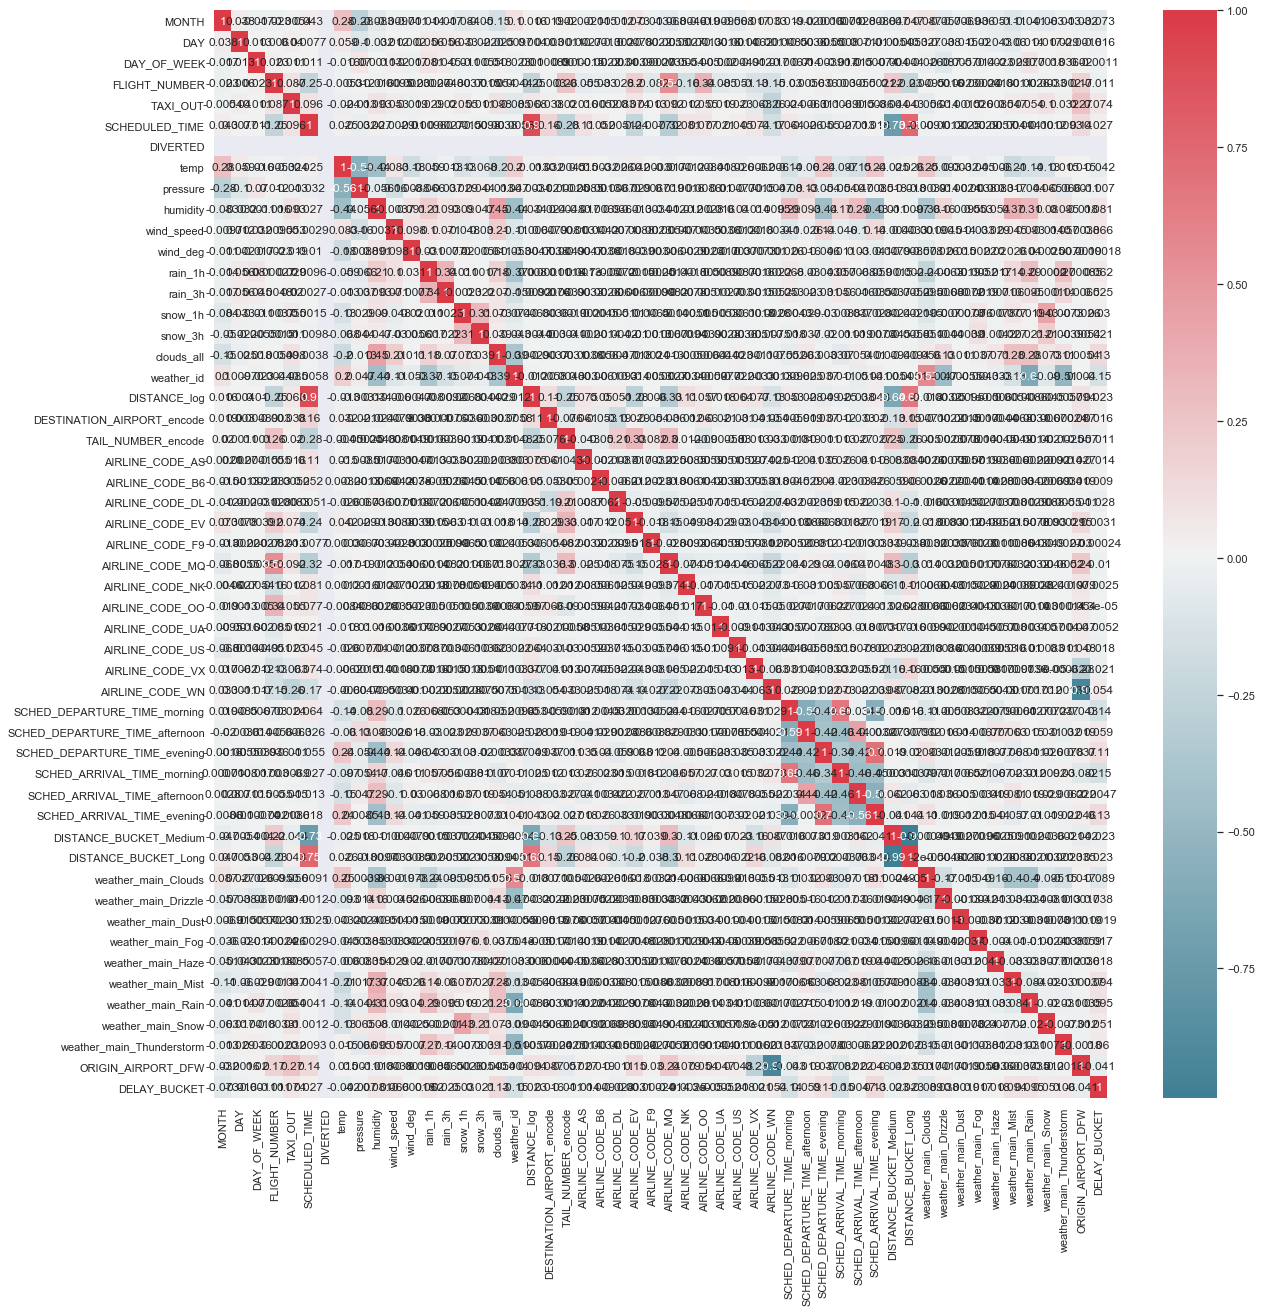

In [150]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Create heatmap
sns.heatmap(df_delay.corr(), cmap=cmap, annot = True)

We have too many features for this to be useful. Let's print out the variables that have a correlation greater than 0.8.

In [151]:
# Create correlation matrix with absolute values only
corr_matrix_abs = df_delay.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

['DISTANCE_log', 'DISTANCE_BUCKET_Long', 'ORIGIN_AIRPORT_DFW']


In [152]:
col_to_drop7 = ['DISTANCE_log', 'DIVERTED']

df_delay = df_delay.drop(columns = col_to_drop7)

### 1.12 Cancelled  Correlations/Feature Removal

In [153]:
col_to_drop6 = ['DEPARTED', 
                'DIVERTED', 
                'ARRIVED', 
                'DIVERTED',
                'ACTUAL_DEPARTURE_TIME_morning',
                'ACTUAL_DEPARTURE_TIME_afternoon',
                'ACTUAL_DEPARTURE_TIME_evening',
                'ACTUAL_DEPARTURE_TIME_N', 
                'ACTUAL_ARRIVAL_TIME_morning',
                'ACTUAL_ARRIVAL_TIME_afternoon',
                'ACTUAL_ARRIVAL_TIME_evening', 
                'ACTUAL_ARRIVAL_TIME_N']

df_cancel = df_cancel.drop(columns = col_to_drop6)

In [154]:
# Total cancel check
df_cancel['CANCELLED'].value_counts()

0    195553
1      5683
Name: CANCELLED, dtype: int64

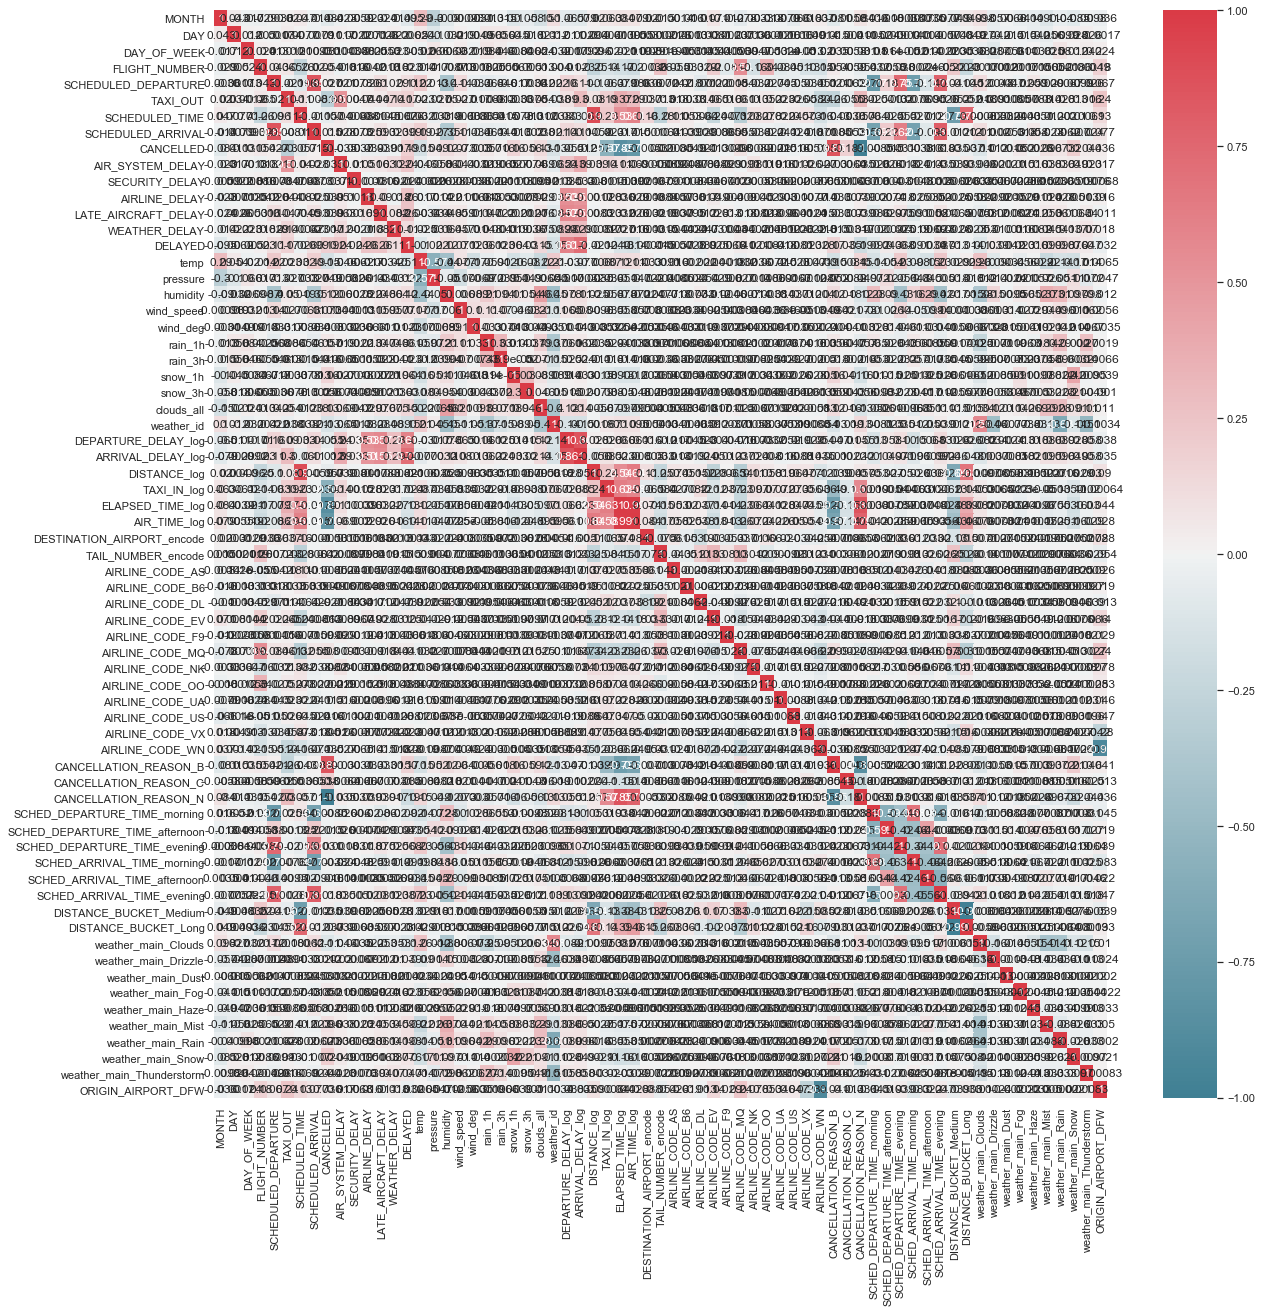

In [155]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Create heatmap
sns.heatmap(df_cancel.corr(), cmap=cmap, annot = True)

In [156]:
# Create correlation matrix with absolute values only
corr_matrix_abs = df_cancel.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(to_drop)

['SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY_log', 'DISTANCE_log', 'ELAPSED_TIME_log', 'AIR_TIME_log', 'CANCELLATION_REASON_B', 'CANCELLATION_REASON_N', 'SCHED_ARRIVAL_TIME_evening', 'DISTANCE_BUCKET_Long', 'ORIGIN_AIRPORT_DFW']


In [157]:
col_to_drop8 = ['ARRIVAL_DELAY_log', 'DISTANCE_log', 'ELAPSED_TIME_log', 'AIR_TIME_log']

df_cancel = df_cancel.drop(columns = col_to_drop8)

## 2. Data Preparation Part 2

### 2.1 Canceled Data Set

- **[5 points]** Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [158]:
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201236 entries, 0 to 204226
Data columns (total 63 columns):
MONTH                             201236 non-null int64
DAY                               201236 non-null int64
DAY_OF_WEEK                       201236 non-null int64
FLIGHT_NUMBER                     201236 non-null int64
SCHEDULED_DEPARTURE               201236 non-null int32
TAXI_OUT                          201236 non-null float64
SCHEDULED_TIME                    201236 non-null int32
SCHEDULED_ARRIVAL                 201236 non-null int32
CANCELLED                         201236 non-null int64
AIR_SYSTEM_DELAY                  201236 non-null float64
SECURITY_DELAY                    201236 non-null float64
AIRLINE_DELAY                     201236 non-null float64
LATE_AIRCRAFT_DELAY               201236 non-null float64
WEATHER_DELAY                     201236 non-null float64
DELAYED                           201236 non-null int64
temp                              201

Our final data set for cancellations includes all numeric data types. 

The following data types that were originally category or object have seen been encoded:
- `DESTINATION_AIRPORT`
- `TAIL_NUMBER`
- `AIRLINE_CODE`
- `CANCELLATION_REASON`
- `SCHEDULED_DEPARTURE`, `SCHEDULED_ARRIVAL`, `ACTUAL_DEPARTURE`, `ACTUAL_ARRIVAL` -  these are all now buckets of the time of day
- `DISTANCE`
- `weather_main`

The new variables we created outside of the encoded ones above include `DELAYED` which was a binary variable we made based on if the arrival delay was greather than 0.

We have removed all variables that were above 0.9 for correlation. There are still some variables we suspect may cause issues in modeling since we expect there to be a high correlation to `CANCELLED` (such as `ACTUAL_ARRIVAL` or `ACTUAL_DEPARTURE`) but we will address and remove these later if we see overfit in initial models.

## 2.2 Delay Data Set

In [159]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195553 entries, 0 to 204226
Data columns (total 50 columns):
MONTH                             195553 non-null int64
DAY                               195553 non-null int64
DAY_OF_WEEK                       195553 non-null int64
FLIGHT_NUMBER                     195553 non-null int64
TAXI_OUT                          195553 non-null float64
SCHEDULED_TIME                    195553 non-null int32
temp                              195553 non-null float64
pressure                          195553 non-null int64
humidity                          195553 non-null int64
wind_speed                        195553 non-null float64
wind_deg                          195553 non-null int64
rain_1h                           195553 non-null float64
rain_3h                           195553 non-null float64
snow_1h                           195553 non-null float64
snow_3h                           195553 non-null float64
clouds_all                        1

Talk about the Cancelation Data Set

Talk about adding weather into the data sets. 

In [160]:
# # Save data
#df_cancel.to_csv('../Data/df_cancel.csv', index=False)
#df_delay.to_csv('../Data/df_delay.csv', index=False)

In [161]:
# # Load data from here to save time
# df_cancel = pd.read_csv('../Data/df_cancel.csv')
# df_delay = pd.read_csv('../Data/df_delay.csv')

# 3. Modeling & Evaluation 1

> **[10 points]** Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

As part of this lab, we're creating models to evaluate two classification problems. The first problem is a binary classification as to whether a flight will be cancelled or not.  The second is a multi-classification problem — classifying flight delays based on weather, flight, airline, and calendar data.

Our evaluation metrics include:

**Receiver Operation Characteristic (ROC) Curves**

**Accuracy**

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

**Precision**

$Precision (p) = \frac{TP}{PP}$

**Recall**

$Recall (r) = \frac{TP}{P}$

## 3.1 Cancellation Data Metrics

For the cancellation data, we will first run a grid search across multiple parameters using accuracy as our optimum scoring method. Since it's a binary classification, we do want to make our models as accurate as possible in terms of predicting cancellation. However, when choosing a final best model, we will also take into account the precision and recall in addition to the accuracy. 

While ideally our model will have the highest accuracy possible without overfit, the secondary concern is to make sure we minimize our false negative rate. We would rather predict the flight is cancelled, and then it is not, then to predict it will not be cancelled, but it is. Therefore, after accuracy we will choose the best model on higher recall.

## 3.2 Delay Data Metrics

Add text here

## 4. Modeling and Evaluation 2

> **[10 points]** Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.

We chose to use Stratified Shuffle split to create our training and test groups instead of another method such as random sampling. Random sampling creates the training and test groups by treating each member of the population as though it has an equal shot at being selected. This is best when there is not much is known about the population, or the data is not easily grouped. We used random sampling in the Mini Lab. We decided Stratified Shuffle Split sampling is best for our data since it can be broken down into subgroups such as time of day or reason for cancelation/delay. The samples are taken for each subgroup using a ratio of the subgroup to the population. This ensures we get data in each subgroup, avoiding sampling bias.

### 4.1 Cancel Data Set

In [162]:
#df_cancel.info()

In [163]:
#move response to end
cols = list(df_cancel.columns.values) 
cols.pop(cols.index('CANCELLED')) 
df_cancel = df_cancel[cols+['CANCELLED']]
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201236 entries, 0 to 204226
Data columns (total 63 columns):
MONTH                             201236 non-null int64
DAY                               201236 non-null int64
DAY_OF_WEEK                       201236 non-null int64
FLIGHT_NUMBER                     201236 non-null int64
SCHEDULED_DEPARTURE               201236 non-null int32
TAXI_OUT                          201236 non-null float64
SCHEDULED_TIME                    201236 non-null int32
SCHEDULED_ARRIVAL                 201236 non-null int32
AIR_SYSTEM_DELAY                  201236 non-null float64
SECURITY_DELAY                    201236 non-null float64
AIRLINE_DELAY                     201236 non-null float64
LATE_AIRCRAFT_DELAY               201236 non-null float64
WEATHER_DELAY                     201236 non-null float64
DELAYED                           201236 non-null int64
temp                              201236 non-null float64
pressure                          2

In [164]:
df_cancel['CANCELLED'].value_counts()

0    195553
1      5683
Name: CANCELLED, dtype: int64

In [165]:
#create X and y for cancellation data set
if 'CANCELLED' in df_cancel:
    y_can = df_cancel['CANCELLED'].values
    X_can = df_cancel.iloc[:,:-1].values

In [166]:
print(X_can.shape)
print(y_can.shape)

(201236, 62)
(201236,)


In [167]:
#scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_can)

X_can = scaler.transform(X_can)

#### 4.1.1 Undersampling

We know that our cancellation data set is highly imbalanced with around ~5600 cancellations versus ~200,000 total observations. First, we will undersample our majority class to get a 2:1 ratio of non-cancelled to cancelled flights. This will significantly decrease our overall data size, but it will also allow us to run models much faster and therefore be able to make decisions sooner on if undersampling is the correct method for best performance.

In [168]:
#adapted from https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

#check current class count
print(Counter(y_can))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
# fit and apply the transform
X_can_under, y_can_under = undersample.fit_resample(X_can, y_can)
# summarize class distribution
print(Counter(y_can_under))

Counter({0: 195553, 1: 5683})
Counter({0: 11366, 1: 5683})


This undersampling has now decreased our total count of 'non-cancels' from 195,553 to 11,366.

#### 4.1.2 SMOTE + Undersampling

We choose to do not standard oversampling on the data as we wanted to avoid adding too many cancellations for fear of artifically skewing the models. A compromise on that concern, but also to increase our overall cancellation size, was to use SMOTE (**S**ynthetic **M**inority **O**versampling **TE**chnique) in combination with undersampling. We will create a pipeline to first perform SMOTE on the data, then to undersample that new data set.

In [169]:
#adapted from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 

#check current class count
print(Counter(y_can))
# define pipeline
over = SMOTE(sampling_strategy=0.2, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_can_smote, y_can_smote = pipeline.fit_resample(X_can, y_can)
# summarize the new class distribution
counter = Counter(y_can_smote)
print(counter)

Counter({0: 195553, 1: 5683})
Counter({0: 78220, 1: 39110})


The SMOTE and undersampled data (which for simplicity's sake we will refer to later just as SMOTE) now has 39,110 cancellation values.

#### 4.1.3 Stratified Shuffle Split

Below we will perform stratified shuffle split to create three train/test splits for modelling:
1. Split on the original data
2. Split on undersampled data
3. Split on SMOTE and undersampled data

In [170]:
from sklearn.model_selection import StratifiedShuffleSplit

sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in sss.split(X_can, y_can):
    X_train_can, X_test_can = X_can[train_index], X_can[test_index]
    y_train_can, y_test_can = y_can[train_index], y_can[test_index]

print(X_train_can.shape, X_test_can.shape, y_train_can.shape, y_test_can.shape)

(160988, 62) (40248, 62) (160988,) (40248,)


In [171]:
for train_index, test_index in sss.split(X_can_under, y_can_under):
    X_train_can_under, X_test_can_under = X_can_under[train_index], X_can_under[test_index]
    y_train_can_under, y_test_can_under = y_can_under[train_index], y_can_under[test_index]

print(X_train_can_under.shape, X_test_can_under.shape, y_train_can_under.shape, y_test_can_under.shape)

(13639, 62) (3410, 62) (13639,) (3410,)


In [172]:
for train_index, test_index in sss.split(X_can_smote, y_can_smote):
    X_train_can_smote, X_test_can_smote = X_can_smote[train_index], X_can_smote[test_index]
    y_train_can_smote, y_test_can_smote = y_can_smote[train_index], y_can_smote[test_index]

print(X_train_can_smote.shape, X_test_can_smote.shape, y_train_can_smote.shape, y_test_can_smote.shape)

(93864, 62) (23466, 62) (93864,) (23466,)


### 4.2 Delay Data Set Train and Test Split

In evaluating the delay data, let's look at the distribution of the buckets.

In [173]:
# Percentages of each delay bucket
df_delay['DELAY_BUCKET'].value_counts() / len(df_delay) * 100

0    50.899245
1    22.679274
2    12.673802
3     7.084524
4     6.663155
Name: DELAY_BUCKET, dtype: float64

In [174]:
df_delay.shape

(195553, 50)

In [175]:
df_delay['DELAY_BUCKET'].value_counts()

0    99535
1    44350
2    24784
3    13854
4    13030
Name: DELAY_BUCKET, dtype: int64

It appears that half of our data `0` reflects flights that departed early (negative delay value in the data set). This was a surprisingly high value. How did the rest of the buckets break down?

22.7% arrived on-time or between 1 and 10 minutes late
12.7% arrived late (between 11 and 30 min)
7.1% arrived very late (between 31 and 60 min)
6.7% arrived extremely late (over 61 min)

In [176]:
# Create X and y for delay data set
if 'DELAY_BUCKET' in df_delay:
    y_del = df_delay['DELAY_BUCKET'].values
    X_del = df_delay.iloc[:,:-1].values

In [177]:
print(X_del.shape)
print(y_del.shape)

(195553, 49)
(195553,)


#### 4.2.1 Undersampling

In [178]:
# Source: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

# Define undersample strategy
undersample = RandomUnderSampler(sampling_strategy = 'majority', random_state = 42)

# Fit and apply the transform
X_del_under, y_del_under = undersample.fit_resample(X_del, y_del)

In [179]:
print(X_del_under.shape)
print(y_del_under.shape)

(109048, 49)
(109048,)


In [180]:
# Summarize the new class distribution
counter = Counter(y_del_under)
print(counter)

Counter({1: 44350, 2: 24784, 3: 13854, 0: 13030, 4: 13030})


In [181]:
df_delay['DELAY_BUCKET'].value_counts() / len(df_delay) * 100

0    50.899245
1    22.679274
2    12.673802
3     7.084524
4     6.663155
Name: DELAY_BUCKET, dtype: float64

After undersampling, our classes broke down as follows:

- Class 0: 13,030
- Class 1: 44,350
- Class 2: 24,784 
- Class 3: 13,854
- Class 4: 13,030

** add more here **


#### 4.2.2 Oversampling Using SMOTE

We know that our delay data set is relatively balanced when it coes to flights that departed early vs. on-time or late. Since the data between the classes is slightly imbalanced, we'll transform the data using SMOTE (**S**ynthetic **M**inority **O**versampling **TE**chnique) and see if that returns better performance. This code is adapted from [Machine Learning Mastery](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

In [182]:
# Oversample using SMOTE
oversample = SMOTE()
X_del_smote, y_del_smote = oversample.fit_resample(X_del, y_del)

In [183]:
print(X_del_smote.shape)
print(y_del_smote.shape)

(497675, 49)
(497675,)


In [184]:
# Summarize the new class distribution
counter = Counter(y_del_smote)
print(counter)

Counter({4: 99535, 1: 99535, 0: 99535, 2: 99535, 3: 99535})


Using SMOTE, all of our classes now have 99,535 observations in them. 

#### 4.2.3 Stratified Shuffle Split

Below we will perform stratified shuffle split to create two train/test splits for modelling:
1. Split on the original data
2. Split on SMOTE and oversampled data

In [185]:
from sklearn.model_selection import StratifiedShuffleSplit

sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in sss.split(X_del, y_del):
    X_train_del, X_test_del = X_del[train_index], X_del[test_index]
    y_train_del, y_test_del = y_del[train_index], y_del[test_index]

print("Split on Original Data:\n")
print('Training Features Shape:', X_train_del.shape)
print('Training Labels Shape:', y_train_del.shape)
print('Testing Features Shape:', X_test_del.shape)
print('Testing Labels Shape:', y_test_del.shape)

Split on Original Data:

Training Features Shape: (156442, 49)
Training Labels Shape: (156442,)
Testing Features Shape: (39111, 49)
Testing Labels Shape: (39111,)


In [186]:
for train_index, test_index in sss.split(X_del_under, y_del_under):
    X_train_del_under, X_test_del_under = X_del_under[train_index], X_del_under[test_index]
    y_train_del_under, y_test_del_under = y_del_under[train_index], y_del_under[test_index]

print("Split on Undersampled Data:\n")
print('Training Features Shape:', X_train_del_under.shape)
print('Training Labels Shape:', y_train_del_under.shape)
print('Testing Features Shape:', X_test_del_under.shape)
print('Testing Labels Shape:', y_test_del_under.shape)

Split on Undersampled Data:

Training Features Shape: (87238, 49)
Training Labels Shape: (87238,)
Testing Features Shape: (21810, 49)
Testing Labels Shape: (21810,)


In [187]:
for train_index, test_index in sss.split(X_del_smote, y_del_smote):
    X_train_del_smote, X_test_del_smote = X_del_smote[train_index], X_del_smote[test_index]
    y_train_del_smote, y_test_del_smote = y_del_smote[train_index], y_del_smote[test_index]

print("Split on Oversampled Data:\n")
print('Training Features Shape:', X_train_del_smote.shape)
print('Training Labels Shape:', y_train_del_smote.shape)
print('Testing Features Shape:', X_test_del_smote.shape)
print('Testing Labels Shape:', y_test_del_smote.shape)

Split on Oversampled Data:

Training Features Shape: (398140, 49)
Training Labels Shape: (398140,)
Testing Features Shape: (99535, 49)
Testing Labels Shape: (99535,)


## 5. Modeling and Evaluation 3

> **[20 points]** Create three different classification/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric.

## 5.1 Cancellations

### 5.1.1 Random Forest

We will test random forest on all three of our data sets - the original, undersampled, and the one with SMOTE + undersampling. First, we set a grid search and run it on the original data to see what kind of results we get back, even though we know the data is highly unbalanced and will likely skew to overfit since our majority class is `0` (or non-cancelled flights). In this case, if the model guessed that the flight was not cancelled for everything, it would still be between 97 and 98% accuracy as only 2% of our flights are cancelled. 

In [95]:
%%time
#run random forest on cancellations with grid search

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf_can_rf = RandomForestClassifier(class_weight = 'balanced')

can_rf_params = {'n_estimators':[10, 20, 100],
                   'max_depth': ['None', 10, 20, 100, 200],
                   'criterion': ['gini', 'entropy'],
                   'min_samples_split': [2, 5, 10, 100],
                   'min_samples_leaf': [1, 2, 5, 10, 20],
                   'random_state': [13]
                  }

can_rf_grid = GridSearchCV(estimator = clf_can_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = can_rf_params,
                               cv = 10,
                               scoring = 'accuracy')

can_rf_grid.fit(X_train_can,y_train_can)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 65.7min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 86.8min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 102.0min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 135.9min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 172.9min finished


Wall time: 2h 52min 53s


GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': ['None', 10, 20, 100, 200],
                         'min_samples_leaf': [1, 2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 100],
                         'n_estimators': [10, 20, 100], 'random_state': [13]},
             scoring='accuracy', verbose=1)

In [96]:
#print best estimator
print(can_rf_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_rf_grid.best_score_))

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=10,
                       random_state=13)
Accuracy: 1.0


As expected, we are overfitting our data since we got 100% accuracy on multiple models. Let's check variable importance to see which variables it is highlighting in these trees before proceeding to complete the same exercise on a more balanced data set.

In [188]:
#run best estimator params
from sklearn import metrics 

rf_v0 = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=10,
                       random_state=13)

rf_v0.fit(X_train_can,y_train_can)
y_pred_v0 = rf_v0.predict(X_test_can)

print("Accuracy:",metrics.accuracy_score(y_test_can, y_pred_v0))
print("Kappa:",metrics.cohen_kappa_score(y_test_can,y_pred_v0))
print("Precision:",metrics.precision_score(y_test_can,y_pred_v0))
print("Recall:",metrics.recall_score(y_test_can,y_pred_v0))

features_can = df_cancel.iloc[:,:-1]

feature_imp_v0 = pd.Series(rf_v0.feature_importances_,index=features_can.columns).sort_values(ascending=False)
feature_imp_v0

Accuracy: 1.0
Kappa: 1.0
Precision: 1.0
Recall: 1.0


TAXI_IN_log                       2.511474e-01
TAXI_OUT                          1.931730e-01
DEPARTURE_DELAY_log               1.879428e-01
CANCELLATION_REASON_N             1.793339e-01
DELAYED                           8.674505e-02
weather_main_Clouds               2.509360e-02
AIRLINE_DELAY                     1.452480e-02
weather_id                        1.081651e-02
snow_1h                           9.047308e-03
pressure                          8.937405e-03
CANCELLATION_REASON_B             6.900868e-03
wind_speed                        5.269742e-03
weather_main_Mist                 4.608622e-03
MONTH                             4.143393e-03
humidity                          3.437768e-03
clouds_all                        2.983835e-03
weather_main_Rain                 2.658086e-03
SCHEDULED_DEPARTURE               1.202528e-03
SCHEDULED_TIME                    8.939248e-04
AIR_SYSTEM_DELAY                  6.903470e-04
SCHED_ARRIVAL_TIME_evening        2.161769e-04
DAY_OF_WEEK  

With our original data set and including the argument `class_weight = 'balanced'`, we are getting 100% accuracy across multiple fits in our grid search. Checking the variable importance shows that several of our variables that may be easily correlated to `CANCELLATION` such as `TAXI_IN_log` rank high in variable importance. This is because if the `TAXI_IN_log` is a non-zero value, it is most likely not a cancelled flight, and we would not catch this in our correlation matrix. Let's try it on multiple K's too to make sure it's not just random forest that overfits on this data.

### 5.1.2 KNN

In [98]:
%%time
from sklearn.neighbors import KNeighborsClassifier

#set k_range to try k values from 1 to 15
k_range = range(1,16)

#make a list of each accuracy (defined later) for each k
scores_v0 = {}
scores_v0_list = []

#make a list of kappa for each k
kappa_v0 = {}
kappa_v0_list = []

#fit data
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_can,y_train_can)
    
    y_pred = knn.predict(X_test_can)
    
    scores_v0[k] = metrics.accuracy_score(y_test_can,y_pred)
    scores_v0_list.append(scores_v0[k])
    
    kappa_v0[k] = metrics.cohen_kappa_score(y_test_can,y_pred)
    kappa_v0_list.append(kappa_v0[k])

print(scores_v0)
print(kappa_v0)

{1: 0.999950308089843, 2: 0.9998757702246074, 3: 0.999900616179686, 4: 0.9998260783144504, 5: 0.9998260783144504, 6: 0.9997763864042933, 7: 0.9998012323593719, 8: 0.9997515404492149, 9: 0.9997763864042933, 10: 0.9997018485390579, 11: 0.9997018485390579, 12: 0.9996521566289008, 13: 0.9996521566289008, 14: 0.9995776187636652, 15: 0.9995776187636652}
{1: 0.9990941507295105, 2: 0.9977324698419842, 3: 0.9981867517318339, 4: 0.9968227387861747, 5: 0.9968227387861747, 6: 0.9959114480267922, 7: 0.9963672886200158, 8: 0.995455216504258, 9: 0.9959114480267922, 10: 0.9945415786579631, 11: 0.9945415786579631, 12: 0.9936263710458942, 13: 0.9936263710458942, 14: 0.9922506074557154, 15: 0.9922506074557154}
Wall time: 3h 24min 14s


In [99]:
#find key (k-value) for best accuracy
max_key = max(scores_v0, key=lambda k: scores_v0[k])

print("Best K-value for accuracy:",max_key)
print("Best Accuracy:",max(scores_v0_list))
print("Best Kappa:",kappa_v0[max_key])

Best K-value for accuracy: 1
Best Accuracy: 0.999950308089843
Best Kappa: 0.9990941507295105


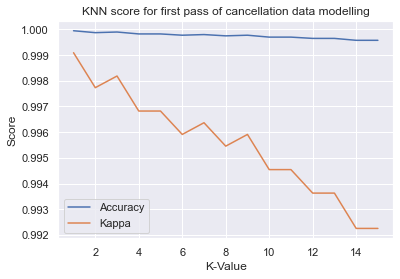

In [100]:
plt.plot(k_range,scores_v0_list)
plt.plot(k_range,kappa_v0_list)
plt.xlabel("K-Value")
plt.ylabel("Score")
plt.legend(["Accuracy","Kappa"])
plt.title("KNN score for first pass of cancellation data modelling")
plt.show()

Even with KNN, we see the same overfit with close to 100% accuracy across multiple K-values. This still could be a symptom of our imbalanced data set, but one variable we should remove is `CANCELLATION_REASON` as logically we know if `CANCELLATION_REASON_N` = `1`, then automatically `CANCELLED` will be `0`.

In [189]:
df_cancel.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_ARRIVAL', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DELAYED', 'temp', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h',
       'clouds_all', 'weather_id', 'DEPARTURE_DELAY_log', 'TAXI_IN_log',
       'DESTINATION_AIRPORT_encode', 'TAIL_NUMBER_encode', 'AIRLINE_CODE_AS',
       'AIRLINE_CODE_B6', 'AIRLINE_CODE_DL', 'AIRLINE_CODE_EV',
       'AIRLINE_CODE_F9', 'AIRLINE_CODE_MQ', 'AIRLINE_CODE_NK',
       'AIRLINE_CODE_OO', 'AIRLINE_CODE_UA', 'AIRLINE_CODE_US',
       'AIRLINE_CODE_VX', 'AIRLINE_CODE_WN', 'CANCELLATION_REASON_B',
       'CANCELLATION_REASON_C', 'CANCELLATION_REASON_N',
       'SCHED_DEPARTURE_TIME_morning', 'SCHED_DEPARTURE_TIME_afternoon',
       'SCHED_DEPARTURE_TIME_evening', 'SCHED_ARRIVAL_TIME_morning',
       'SCHED_ARRIVAL_T

In [190]:
#separate data to features and target variable and drop cancel columns
cols = ['CANCELLATION_REASON_B', 'CANCELLATION_REASON_C', 'CANCELLATION_REASON_N']
df_cancel = df_cancel.drop(columns = cols)

#create X and y for cancellation data set
if 'CANCELLED' in df_cancel:
    y_can = df_cancel['CANCELLED'].values
    X_can = df_cancel.iloc[:,:-1].values
    
num_cv_iterations = 10
num_instances = len(y_can)

X_can.shape, y_can.shape

((201236, 59), (201236,))

After removing the `CANCELLATION_REASON` variable, we repeat the undersampling, undersampling + SMOTE, and test/train splits for all.

In [191]:
# Random undersampling

#check current class count
print(Counter(y_can))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
# fit and apply the transform
X_can_under, y_can_under = undersample.fit_resample(X_can, y_can)
# summarize class distribution
print(Counter(y_can_under))

Counter({0: 195553, 1: 5683})
Counter({0: 11366, 1: 5683})


In [192]:
#adapted from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 

#check current class count
print(Counter(y_can))
# define pipeline
over = SMOTE(sampling_strategy=0.2, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_can_smote, y_can_smote = pipeline.fit_resample(X_can, y_can)
# summarize the new class distribution
counter = Counter(y_can_smote)
print(counter)

Counter({0: 195553, 1: 5683})
Counter({0: 78220, 1: 39110})


In [193]:
sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in sss.split(X_can, y_can):
    X_train_can, X_test_can = X_can[train_index], X_can[test_index]
    y_train_can, y_test_can = y_can[train_index], y_can[test_index]

print(X_train_can.shape, X_test_can.shape, y_train_can.shape, y_test_can.shape)

for train_index, test_index in sss.split(X_can_under, y_can_under):
    X_train_can_under, X_test_can_under = X_can_under[train_index], X_can_under[test_index]
    y_train_can_under, y_test_can_under = y_can_under[train_index], y_can_under[test_index]

print(X_train_can_under.shape, X_test_can_under.shape, y_train_can_under.shape, y_test_can_under.shape)

for train_index, test_index in sss.split(X_can_smote, y_can_smote):
    X_train_can_smote, X_test_can_smote = X_can_smote[train_index], X_can_smote[test_index]
    y_train_can_smote, y_test_can_smote = y_can_smote[train_index], y_can_smote[test_index]

print(X_train_can_smote.shape, X_test_can_smote.shape, y_train_can_smote.shape, y_test_can_smote.shape)

(160988, 59) (40248, 59) (160988,) (40248,)
(13639, 59) (3410, 59) (13639,) (3410,)
(93864, 59) (23466, 59) (93864,) (23466,)


#### Re-Run Random Forest without Cancellation Reason

Now we will re-run our random forest (this time with defaults to save time) on the original data set to see if this has made any impact on the accuracy levels.

In [196]:
%%time
#run random forest on cancellations

#test using standard classifier with defaults
clf_can_rf = RandomForestClassifier(class_weight = 'balanced', random_state = 13)

clf_can_rf.fit(X_train_can,y_train_can)
y_pred_can = clf_can_rf.predict(X_test_can)

print(metrics.accuracy_score(y_test_can,y_pred_can))

1.0
Wall time: 21.2 s


Unfortunately we still have 100% accuracy. Now that we have removed `CANCELLATION_REASON`, what else is showing high variable importance?

In [197]:
features_can = df_cancel.iloc[:,:-1]

feature_imp = pd.Series(clf_can_rf.feature_importances_,index=features_can.columns).sort_values(ascending=False)
feature_imp

TAXI_OUT                          3.370199e-01
TAXI_IN_log                       2.884402e-01
DEPARTURE_DELAY_log               1.126245e-01
DELAYED                           9.194760e-02
clouds_all                        3.593065e-02
temp                              1.993910e-02
AIRLINE_DELAY                     1.857110e-02
weather_id                        1.688567e-02
humidity                          1.241309e-02
AIR_SYSTEM_DELAY                  1.103664e-02
LATE_AIRCRAFT_DELAY               9.108677e-03
weather_main_Clouds               6.586661e-03
snow_1h                           6.384710e-03
pressure                          4.944247e-03
MONTH                             4.835135e-03
wind_speed                        4.059405e-03
FLIGHT_NUMBER                     2.063466e-03
weather_main_Snow                 1.816481e-03
WEATHER_DELAY                     1.598954e-03
weather_main_Mist                 1.516723e-03
rain_1h                           1.448255e-03
AIRLINE_CODE_

These are some of the same features we saw with high importance during the last run. We still suspect overfit may also be due to the imbalance nature of the data. Let's check with our SMOTE data set instead.

In [198]:
#try running with our balanced data sets - unbalanced and SMOTE - if still high, eliminate more features

clf_can_rf_smote = RandomForestClassifier(class_weight = 'balanced', random_state = 13)

clf_can_rf_smote.fit(X_train_can_smote,y_train_can_smote)
y_pred_can_smote = clf_can_rf_smote.predict(X_test_can_smote)

print(metrics.accuracy_score(y_test_can_smote,y_pred_can_smote))

1.0


It is clear this still occurs with a more balanced data set. Therefore, we need to eliminate all other features that reasonably correlate to cancels - meaning anything that is either a 0 or 1 and correlates closely to cancel (i.e. `DELAYED` being 1 means `CANCELLED` will be 0.)

In [199]:
df_cancel.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE',
       'TAXI_OUT', 'SCHEDULED_TIME', 'SCHEDULED_ARRIVAL', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DELAYED', 'temp', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h',
       'clouds_all', 'weather_id', 'DEPARTURE_DELAY_log', 'TAXI_IN_log',
       'DESTINATION_AIRPORT_encode', 'TAIL_NUMBER_encode', 'AIRLINE_CODE_AS',
       'AIRLINE_CODE_B6', 'AIRLINE_CODE_DL', 'AIRLINE_CODE_EV',
       'AIRLINE_CODE_F9', 'AIRLINE_CODE_MQ', 'AIRLINE_CODE_NK',
       'AIRLINE_CODE_OO', 'AIRLINE_CODE_UA', 'AIRLINE_CODE_US',
       'AIRLINE_CODE_VX', 'AIRLINE_CODE_WN', 'SCHED_DEPARTURE_TIME_morning',
       'SCHED_DEPARTURE_TIME_afternoon', 'SCHED_DEPARTURE_TIME_evening',
       'SCHED_ARRIVAL_TIME_morning', 'SCHED_ARRIVAL_TIME_afternoon',
       'SCHED_ARRIVAL_TIME_evening', 'DISTANCE_BUCKET_Medium',
       'DI

In [200]:
cols = ['TAXI_OUT', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 
       'DELAYED', 'DEPARTURE_DELAY_log', 'TAXI_IN_log']

df_cancel = df_cancel.drop(columns = cols)

In [201]:
#create X and y for cancellation data set
if 'CANCELLED' in df_cancel:
    y_can = df_cancel['CANCELLED'].values
    X_can = df_cancel.iloc[:,:-1].values
    
num_cv_iterations = 10
num_instances = len(y_can)

X_can.shape, y_can.shape

#check current class count
print(Counter(y_can))
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
# fit and apply the transform
X_can_under, y_can_under = undersample.fit_resample(X_can, y_can)
# summarize class distribution
print(Counter(y_can_under))

# define pipeline
over = SMOTE(sampling_strategy=0.2, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_can_smote, y_can_smote = pipeline.fit_resample(X_can, y_can)
# summarize the new class distribution
counter = Counter(y_can_smote)
print(counter)

sss=StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in sss.split(X_can, y_can):
    X_train_can, X_test_can = X_can[train_index], X_can[test_index]
    y_train_can, y_test_can = y_can[train_index], y_can[test_index]

print(X_train_can.shape, X_test_can.shape, y_train_can.shape, y_test_can.shape)

for train_index, test_index in sss.split(X_can_under, y_can_under):
    X_train_can_under, X_test_can_under = X_can_under[train_index], X_can_under[test_index]
    y_train_can_under, y_test_can_under = y_can_under[train_index], y_can_under[test_index]

print(X_train_can_under.shape, X_test_can_under.shape, y_train_can_under.shape, y_test_can_under.shape)

for train_index, test_index in sss.split(X_can_smote, y_can_smote):
    X_train_can_smote, X_test_can_smote = X_can_smote[train_index], X_can_smote[test_index]
    y_train_can_smote, y_test_can_smote = y_can_smote[train_index], y_can_smote[test_index]

print(X_train_can_smote.shape, X_test_can_smote.shape, y_train_can_smote.shape, y_test_can_smote.shape)

Counter({0: 195553, 1: 5683})
Counter({0: 11366, 1: 5683})
Counter({0: 78220, 1: 39110})
(160988, 50) (40248, 50) (160988,) (40248,)
(13639, 50) (3410, 50) (13639,) (3410,)
(93864, 50) (23466, 50) (93864,) (23466,)


#### Running Random Forest Again!

Now that we have removed more features, hopefully we will start to see a more reasonable accuracy performance as we should have removed ALL variables at this point that would lead to overfit. First, we run on original data again just to see if this changed our accuracy.

In [202]:
%%time
#run random forest on cancellations

#test using standard classifier with defaults
clf_can_rf = RandomForestClassifier(class_weight = 'balanced', random_state = 13)

clf_can_rf.fit(X_train_can,y_train_can)
y_pred_can = clf_can_rf.predict(X_test_can)

print(metrics.accuracy_score(y_test_can,y_pred_can))

0.9831047505466111
Wall time: 1min 9s


So far, it looks promising as we got less than 100%, althought it is still high. Next we will run the default random forest settings on our SMOTE and undersampled data as well.

In [203]:
clf_can_rf_smote = RandomForestClassifier(random_state = 13)

clf_can_rf_smote.fit(X_train_can_smote,y_train_can_smote)
y_pred_can_smote = clf_can_rf_smote.predict(X_test_can_smote)

print(metrics.accuracy_score(y_test_can_smote,y_pred_can_smote))

0.9678257905054121


In [204]:
clf_can_rf_under = RandomForestClassifier(random_state = 13)

clf_can_rf_under.fit(X_train_can_under,y_train_can_under)
y_pred_can_under = clf_can_rf_under.predict(X_test_can_under)

print(metrics.accuracy_score(y_test_can_under,y_pred_can_under))

0.8900293255131965


This is better - there is likely still some overfit on the original data and possibly SMOTE sampled data, but with the undersampling we have a more reasonable accuracy at 89%. Let's run grid search on our SMOTE and undersampled data sets to see which of these two will be best to use for the rest of the model building - as it's pretty clear at this point the unbalanced data set is giving us some overfit.

In [115]:
%%time
#run random forest on cancellations with grid search - undersampled data

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf_can_rf = RandomForestClassifier(class_weight = 'balanced')

can_rf_params = {'n_estimators':[20, 50, 100],
                   'max_depth': [10, 20, 100, 200],
                   'criterion': ['gini', 'entropy'],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 5, 10],
                   'random_state': [13]
                  }

can_rf_grid = GridSearchCV(estimator = clf_can_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = can_rf_params,
                               cv = 10,
                               scoring = 'accuracy')

can_rf_grid.fit(X_train_can_under,y_train_can_under)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  7.2min finished


Wall time: 7min 12s


GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 100, 200],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100], 'random_state': [13]},
             scoring='accuracy', verbose=1)

In [116]:
#print best estimator
print(can_rf_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_rf_grid.best_score_))

RandomForestClassifier(class_weight='balanced', max_depth=100, random_state=13)
Accuracy: 0.8899470828322034


In [205]:
rf_v1 = RandomForestClassifier(class_weight='balanced', max_depth=100, random_state=13)

rf_v1.fit(X_train_can_under,y_train_can_under)
y_pred_v1 = rf_v1.predict(X_test_can_under)

print("Accuracy:",metrics.accuracy_score(y_test_can_under, y_pred_v1))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_under,y_pred_v1))
print("Precision:",metrics.precision_score(y_test_can_under,y_pred_v1))
print("Recall:",metrics.recall_score(y_test_can_under,y_pred_v1))

Accuracy: 0.8926686217008798
Kappa: 0.752111026675782
Precision: 0.8783120706575074
Recall: 0.7871591908531222


In [118]:
%%time
#run random forest on cancellations with grid search - SMOTE data

can_rf_params = {'n_estimators':[20, 50, 100],
                   'max_depth': [10, 20, 100, 200],
                   'criterion': ['gini', 'entropy'],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 5, 10],
                   'random_state': [13]
                  }

can_rf_grid = GridSearchCV(estimator = clf_can_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = can_rf_params,
                               cv = 10,
                               scoring = 'accuracy')

can_rf_grid.fit(X_train_can_smote,y_train_can_smote)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 69.1min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 99.2min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 135.9min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 162.3min finished


Wall time: 2h 42min 36s


GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 100, 200],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100], 'random_state': [13]},
             scoring='accuracy', verbose=1)

In [119]:
#print best estimator
print(can_rf_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_rf_grid.best_score_))

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=100, min_samples_split=5, random_state=13)
Accuracy: 0.9683691789772959


In [206]:
rf_v2 = RandomForestClassifier(class_weight='balanced', max_depth=100, random_state=13)

rf_v2.fit(X_train_can_smote,y_train_can_smote)
y_pred_v2 = rf_v2.predict(X_test_can_smote)

print("Accuracy:",metrics.accuracy_score(y_test_can_smote, y_pred_v2))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_smote,y_pred_v2))
print("Precision:",metrics.precision_score(y_test_can_smote,y_pred_v2))
print("Recall:",metrics.recall_score(y_test_can_smote,y_pred_v2))

Accuracy: 0.9679110201994375
Kappa: 0.9270372403992119
Precision: 0.971581054036024
Recall: 0.9309639478394273


We have eliminated the original data set at this point for model building based on the high accuracy on random forest and KNN. Below is the summary of our top RF models on the cancelled data set.

| Data set| Test Accuracy | Precision | Recall
| --- | --- | --- | --- | 
Original | 1.0 | 1.0 | 1.0
Undersampled | 0.893 | 0.878 | 0.787
SMOTE | 0.968 | 0.972 | 0.931

#### KNN 

In [121]:
%%time
#Create KNN Classifier
can_knn_params = {
    "n_neighbors": [1,3,5,7],
    "weights": ["uniform", "distance"],
}

can_knn_grid = GridSearchCV(estimator = KNeighborsClassifier(),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = can_knn_params,
                               cv = 10,
                               scoring = 'accuracy')

can_knn_grid.fit(X_train_can_smote,y_train_can_smote)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   40.3s finished


Wall time: 42.6 s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [122]:
#print best estimator
print(can_knn_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_knn_grid.best_score_))

KNeighborsClassifier(n_neighbors=1)
Accuracy: 0.9239325024150917


In [207]:
knn_v0 = KNeighborsClassifier(n_neighbors=1)

knn_v0.fit(X_train_can_smote,y_train_can_smote)
y_pred_knn_v0 = knn_v0.predict(X_test_can_smote)

print("Accuracy:",metrics.accuracy_score(y_test_can_smote, y_pred_knn_v0))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_smote,y_pred_knn_v0))
print("Precision:",metrics.precision_score(y_test_can_smote,y_pred_knn_v0))
print("Recall:",metrics.recall_score(y_test_can_smote,y_pred_knn_v0))

Accuracy: 0.9305377993693003
Kappa: 0.846938775510204
Precision: 0.865008252770573
Recall: 0.9379953975965226


In [124]:
%%time
#Create KNN Classifier - run on under sampled data

can_knn_grid.fit(X_train_can_under,y_train_can_under)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.9s finished


Wall time: 3.31 s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [125]:
#print best estimator
print(can_knn_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_knn_grid.best_score_))

KNeighborsClassifier(n_neighbors=7, weights='distance')
Accuracy: 0.7179412220326474


In [211]:
knn_v1 = KNeighborsClassifier(n_neighbors=7, weights='distance')

knn_v1.fit(X_train_can_under,y_train_can_under)
y_pred_knn_v1 = knn_v1.predict(X_test_can_under)

print("Accuracy:",metrics.accuracy_score(y_test_can_under, y_pred_knn_v1))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_under,y_pred_knn_v1))
print("Precision:",metrics.precision_score(y_test_can_under,y_pred_knn_v1))
print("Recall:",metrics.recall_score(y_test_can_under,y_pred_knn_v1))

Accuracy: 0.7178885630498534
Kappa: 0.3525353089530928
Precision: 0.5835721107927412
Recall: 0.5373790677220757


This is decent performance but we have room to improve. Since our grid search only went up to 7, let's run additional `n_neighbors` values and see if we can increase accuracy.

In [127]:
%%time
#update the grid to run higher K to see if accuracy increases

can_knn_params = {
    "n_neighbors": [7,9,11,13],
    "weights": ["uniform", "distance"],
}

can_knn_grid.fit(X_train_can_under,y_train_can_under)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.8s finished


Wall time: 3.17 s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [128]:
#print best estimator
print(can_knn_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_knn_grid.best_score_))

KNeighborsClassifier(n_neighbors=7, weights='distance')
Accuracy: 0.7179412220326474


The optimum number of neighbors is still 7, so no need to modify parameters again.

Below is the summary of the best performing KNN models on our undersampled and SMOTE data.

| Data set| Test Accuracy | Precision | Recall
| --- | --- | --- | --- | 
Undersampled | 0.718 | 0.583 | 0.538
SMOTE | 0.931 | 0.865 | 0.938

### SVM

In [129]:
%%time


#Create SVM Classifier
can_svm_params = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "alpha": [0.0001, 0.001, 0.01],
    "random_state": [42]
}

can_svm_grid = GridSearchCV(estimator = SGDClassifier(early_stopping=True, class_weight = 'balanced'),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = can_svm_params,
                               cv = 10,
                               scoring = 'accuracy')

can_svm_grid.fit(X_train_can_smote,y_train_can_smote)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.4s finished


Wall time: 16.2 s


GridSearchCV(cv=10,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'random_state': [42]},
             scoring='accuracy', verbose=1)

In [130]:
#print best estimator
print(can_svm_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_svm_grid.best_score_))

SGDClassifier(alpha=0.001, class_weight='balanced', early_stopping=True,
              random_state=42)
Accuracy: 0.631379967457976


In [208]:
svm_v1 = SGDClassifier(class_weight='balanced', early_stopping=True,
              penalty='elasticnet', random_state=42)

svm_v1.fit(X_train_can_smote,y_train_can_smote)
y_pred_svm_v1 = svm_v1.predict(X_test_can_smote)

print("Accuracy:",metrics.accuracy_score(y_test_can_smote, y_pred_svm_v1))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_smote,y_pred_svm_v1))
print("Precision:",metrics.precision_score(y_test_can_smote,y_pred_svm_v1))
print("Recall:",metrics.recall_score(y_test_can_smote,y_pred_svm_v1))

Accuracy: 0.3333333333333333
Kappa: 0.0
Precision: 0.3333333333333333
Recall: 1.0


In [132]:
#run grid search on undersampled data
can_svm_grid.fit(X_train_can_under,y_train_can_under)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.1s finished


GridSearchCV(cv=10,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'random_state': [42]},
             scoring='accuracy', verbose=1)

In [133]:
#print best estimator
print(can_svm_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(can_svm_grid.best_score_))

SGDClassifier(alpha=0.001, class_weight='balanced', early_stopping=True,
              penalty='l1', random_state=42)
Accuracy: 0.5716681763317505


In [209]:
svm_v2 = SGDClassifier(alpha=0.001, class_weight='balanced', early_stopping=True,
              penalty='l1', random_state=42)

svm_v2.fit(X_train_can_under,y_train_can_under)
y_pred_svm_v2 = svm_v2.predict(X_test_can_under)

print("Accuracy:",metrics.accuracy_score(y_test_can_under, y_pred_svm_v2))
print("Kappa:",metrics.cohen_kappa_score(y_test_can_under,y_pred_svm_v2))
print("Precision:",metrics.precision_score(y_test_can_under,y_pred_svm_v2))
print("Recall:",metrics.recall_score(y_test_can_under,y_pred_svm_v2))

Accuracy: 0.6621700879765395
Kappa: 0.16392004423541306
Precision: 0.4896265560165975
Recall: 0.3113456464379947


SVM (SGDClassifier) does not appear to be a good model type for this data. Our highest accuracy for multiple grid search parameters only tops out at 66%, and our recall is only at 31%. At this point, we will need to choose our best model between random forest and KNN.

### 5.1.4 Top Models & Data Sets

| Model Type | Data set| Test Accuracy | Precision | Recall
| --- | --- | --- | --- | --- |
| Random Forest | Undersampled | 0.893 | 0.878 | 0.787
| Random Forest | SMOTE | 0.968 | 0.972 | 0.931
| KNN | Undersampled | 0.718 | 0.583 | 0.538
| KNN | SMOTE | 0.931 | 0.865 | 0.938
| SVM | Undersampled | 0.662 | 0.500 | 0.311
| SVM | SMOTE | 0.333 | 0.333 | 1.0

For our cancellation classification model, the top performing models are Random Forest and KNN. 

Undersampled data set:
- Random Forest model performs better than KNN at overall 89.3% accuracy vs 71.8% accuracy
- The random forest model also has higher recall at 0.787 versus 0.538 from KNN

SMOTE data set:
- Random Forest model also performs better than KNN here at 96.8% accuracy versus 93.1%, but we must be wary of such high accuracy performance on future data sets.
- However, the KNN model has a slightly higher recall at 0.938 versus 0.931 on the random forest model. To make the final decision between these two, we will also compare AUC by way of ROC curves in section X.X.

## 5.2 Delays

### 5.2.1 Random Forest

#### Original Data

In [135]:
%%time

from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, 
                            n_jobs = -1,
                            random_state = 42)

# Train the model on training data
rf.fit(X_train_del, y_train_del)

Wall time: 2min 17s


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

Now that our model has been trained, we'll calculate predictions on our testing data set. 

In [136]:
# Source: https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

# Importing confusion matrix
from sklearn.metrics import confusion_matrix

# Use the forest's predict method on the test data
y_pred_del = rf.predict(X_test_del)

# Define confusion matrix
confusion = confusion_matrix(y_test_del, y_pred_del)

print('Confusion Matrix\n')
print(confusion)

# Importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_del, y_pred_del)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_del, y_pred_del, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_del, y_pred_del, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_del, y_pred_del, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_del, y_pred_del, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_del, y_pred_del, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_del, y_pred_del, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del, y_pred_del, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del, y_pred_del, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del, y_pred_del, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_del, y_pred_del, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))

Confusion Matrix

[[18051  1443   273    67    73]
 [ 5988  2345   336   103    98]
 [ 2870   903   941   117   126]
 [ 1459   383   228   530   171]
 [ 1208   268   188   116   826]]

Accuracy: 0.58

Micro Precision: 0.58
Micro Recall: 0.58
Micro F1-score: 0.58

Macro Precision: 0.55
Macro Recall: 0.37
Macro F1-score: 0.41

Weighted Precision: 0.55
Weighted Recall: 0.58
Weighted F1-score: 0.53

Classification Report

              precision    recall  f1-score   support

     Class 0       0.61      0.91      0.73     19907
     Class 1       0.44      0.26      0.33      8870
     Class 2       0.48      0.19      0.27      4957
     Class 3       0.57      0.19      0.29      2771
     Class 4       0.64      0.32      0.42      2606

    accuracy                           0.58     39111
   macro avg       0.55      0.37      0.41     39111
weighted avg       0.55      0.58      0.53     39111



Here we have printed a number of performance metrics including a confusion matrix and accuracy score. However, since this is a random forest model with an imbalanced data set, other metrics may be more appropriate. 

Recall tells us how well our model predicted delays within a group real delays and false on-time/early flights. Precision tells us how well the model predicted delays with in a group of real dealys and false delays. The F1 score is a weighted average of both precision and recall. All three scores run on a 0 to 1 scale with 0 indicating a completely incorrect result and 1 indicating a perfect prediction. 

Looking at the F! scores in the classification report, class 0, which contained the bulk of the data, had the best score which isn't surprising. Interestingly, the F! scores for classes 1-3 were within 0.06 of one another, but the model did a better job (0.42) predicting extremely long delays. 

Overall this model appears to be hampered by the imbalanced nature of the data.

#### Undersampled

In [137]:
%%time

from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, 
                            n_jobs = -1,
                            random_state = 42)

# Train the model on training data
rf.fit(X_train_del_under, y_train_del_under)

Wall time: 56.8 s


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [138]:
# Source: https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

# Importing confusion matrix
from sklearn.metrics import confusion_matrix

# Use the forest's predict method on the test data
y_pred_del_under = rf.predict(X_test_del_under)

# Define confusion matrix
confusion = confusion_matrix(y_test_del_under, y_pred_del_under)

print('Confusion Matrix\n')
print(confusion)

# Importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_del_under, y_pred_del_under)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_del_under, y_pred_del_under, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_del_under, y_pred_del_under, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_del_under, y_pred_del_under, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_del_under, y_pred_del_under, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_del_under, y_pred_del_under, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_del_under, y_pred_del_under, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_under, y_pred_del_under, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_under, y_pred_del_under, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_under, y_pred_del_under, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_del_under, y_pred_del_under, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))

Confusion Matrix

[[ 251 2102  184   48   21]
 [ 232 7596  768  146  128]
 [ 119 3149 1347  180  162]
 [  57 1547  402  594  171]
 [  63 1180  300  154  909]]

Accuracy: 0.49

Micro Precision: 0.49
Micro Recall: 0.49
Micro F1-score: 0.49

Macro Precision: 0.49
Macro Recall: 0.36
Macro F1-score: 0.37

Weighted Precision: 0.49
Weighted Recall: 0.49
Weighted F1-score: 0.44

Classification Report

              precision    recall  f1-score   support

     Class 0       0.35      0.10      0.15      2606
     Class 1       0.49      0.86      0.62      8870
     Class 2       0.45      0.27      0.34      4957
     Class 3       0.53      0.21      0.31      2771
     Class 4       0.65      0.35      0.45      2606

    accuracy                           0.49     21810
   macro avg       0.49      0.36      0.37     21810
weighted avg       0.49      0.49      0.44     21810



Undersampling the data led to a significant drop in F1 score for class 0, and a class 1 score that was almost double what we got on the original data. However, the overall weighted average F1 score dropped from 0.53 with the original data to 0.44 with the undersampled data.

#### Overampled

In [236]:
%%time

from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, 
                            n_jobs = -1,
                            random_state = 42)

# Train the model on training data
rf.fit(X_train_del_smote, y_train_del_smote)

MemoryError: could not allocate 7340032 bytes

In [237]:
# Source: https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826

# Importing confusion matrix
from sklearn.metrics import confusion_matrix

# Use the forest's predict method on the test data
y_pred_del_smote = rf.predict(X_test_del_smote)

# Define confusion matrix
confusion = confusion_matrix(y_test_del_smote, y_pred_del_smote)

print('Confusion Matrix\n')
print(confusion)

# Importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_del_smote, y_pred_del_smote)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_del_smote, y_pred_del_smote, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_del_smote, y_pred_del_smote, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_del_smote, y_pred_del_smote, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_del_smote, y_pred_del_smote, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_del_smote, y_pred_del_smote, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_del_smote, y_pred_del_smote, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_smote, y_pred_del_smote, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_smote, y_pred_del_smote, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_smote, y_pred_del_smote, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test_del_smote, y_pred_del_smote, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']))

IndexError: list index out of range

The oversampled data using SMOTE has the best performance of the three different splits. 

In [141]:
%%time
#run random forest on cancellations with grid search - undersampled data

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf_del_rf = RandomForestClassifier(class_weight = 'balanced')

del_rf_params = {'n_estimators':[20, 50, 100],
                   'max_depth': [10, 20, 100, 200],
                   'criterion': ['gini', 'entropy'],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 5, 10],
                   'random_state': [13]
                  }

del_rf_grid = GridSearchCV(estimator = clf_del_rf,
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = del_rf_params,
                               cv = 10,
                               scoring = 'accuracy')

del_rf_grid.fit(X_test_del_smote,y_test_del_smote)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 47.5min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed: 77.0min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 112.1min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 160.1min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 194.5min finished


Wall time: 3h 15min 3s


GridSearchCV(cv=10, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 100, 200],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100], 'random_state': [13]},
             scoring='accuracy', verbose=1)

In [143]:
#print best estimator
print(del_rf_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(del_rf_grid.best_score_))

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

### 5.2.2 KNN

#### Original Data w/o Gridsearch

In [145]:
# Source: https://deveshpoojari.medium.com/k-nearest-neighbors-and-its-optimization-2e3f6797af04

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Creating odd list K for KNN
neighbors = list(range(1,8,2))

# Empty list that will hold cv scores
cv_scores = [ ]

# Perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K,
                               n_jobs = -1)
    scores = cross_val_score(knn,
                             X_train_del,
                             y_train_del,
                             cv = 10,
                             scoring = "accuracy"
                            )
    cv_scores.append(scores.mean())

KeyboardInterrupt: 

In [ ]:
# Changing to mis-classification error
mse = [1-x for x in cv_scores]

# Determining the best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))

In [ ]:
# Plot the accuracy score for different values of K
import matplotlib.pyplot as plt
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,8,2)], "Accuracy":knn_list_scores}).set_index("K").plot.bar(rot=0)
    plt.show()
plot_accuracy(cv_scores)

#### Undersampled Data w/o Gridsearch

In [ ]:
# Source: https://deveshpoojari.medium.com/k-nearest-neighbors-and-its-optimization-2e3f6797af04

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Creating odd list K for KNN
neighbors = list(range(1,8,2))

# Empty list that will hold cv scores
cv_scores = [ ]

# Perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K,
                               n_jobs = -1)
    scores = cross_val_score(knn,
                             X_train_del_under,
                             y_train_del_under,
                             cv = 10,
                             scoring = "accuracy"
                            )
    cv_scores.append(scores.mean())

In [ ]:
# Changing to mis-classification error
mse = [1-x for x in cv_scores]

# Determining the best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))

In [ ]:
# Plot the accuracy score for different values of K
import matplotlib.pyplot as plt
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,8,2)], "Accuracy":knn_list_scores}).set_index("K").plot.bar(rot=0)
    plt.show()
plot_accuracy(cv_scores)

#### SMOTE w/o Grid search

In [ ]:
# Source: https://deveshpoojari.medium.com/k-nearest-neighbors-and-its-optimization-2e3f6797af04

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Creating odd list K for KNN
neighbors = list(range(1,8,2))

# Empty list that will hold cv scores
cv_scores = [ ]

# Perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K,
                               n_jobs = -1)
    scores = cross_val_score(knn,
                             X_train_del_smote,
                             y_train_del_smote,
                             cv = 10,
                             scoring = "accuracy"
                            )
    cv_scores.append(scores.mean())

In [ ]:
# Changing to mis-classification error
mse = [1-x for x in cv_scores]

# Determining the best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))

In [ ]:
# Plot the accuracy score for different values of K
import matplotlib.pyplot as plt
def plot_accuracy(knn_list_scores):
    pd.DataFrame({"K":[i for i in range(1,8,2)], "Accuracy":knn_list_scores}).set_index("K").plot.bar(rot=0)
    plt.show()
plot_accuracy(cv_scores)

#### Original Data with Gridsearch

In [144]:
%%time
# # https://realpython.com/knn-python/

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# #Create KNN Classifier
parameters = {
     "n_neighbors": list(range(1,20,2)),
     "weights": ["uniform", "distance"],
 }
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters, cv=10)
gridsearch.fit(X_train_del, y_train_del)
gridsearch.best_params_

KeyboardInterrupt: 

In [ ]:
 test_preds_grid = gridsearch.predict(X_test_del)

In [ ]:
 from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_del, test_preds_grid))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del, test_preds_grid, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del, test_preds_grid, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del, test_preds_grid, average='weighted')))

### under

In [ ]:
%%time
# # https://realpython.com/knn-python/
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# #Create KNN Classifier
parameters = {
     "n_neighbors": list(range(1,20,2)),
     "weights": ["uniform", "distance"],
 }
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters, cv=10)
gridsearch.fit(X_train_del_under, y_train_del_under)
gridsearch.best_params_

In [ ]:
test_preds_grid1 = gridsearch.predict(X_test_del_under)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_del_under, test_preds_grid1))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_under, test_preds_grid1, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_under, test_preds_grid1, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_under, test_preds_grid1, average='weighted')))

Notes on undersampled

### smote

In [ ]:
%%time
# # https://realpython.com/knn-python/
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
# #Create KNN Classifier
parameters = {
     "n_neighbors": list(range(1,20,2)),
     "weights": ["uniform", "distance"],
 }
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters, cv=10)
gridsearch.fit(X_train_del_smote, y_train_del_smote)
gridsearch.best_params_

After running Gridsearch to help select the best parameters of K = 1 and the weights for the KNN classflier model using Smote. 

In [ ]:
test_preds_grid2 = gridsearch.predict(X_test_del_smote)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_del_smote, test_preds_grid2))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_smote, test_preds_grid2, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_smote, test_preds_grid2, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_smote, test_preds_grid2, average='weighted')))

After running a Gridsearch on the KNN model with Smote this was the best prefomring model with the lowest amount of neighbors at 1. This preformed well with all of the evaluatiion metrics that were selected in our model. 

### 5.2.3 SVM

In [ ]:
%%time

from sklearn.linear_model import SGDClassifier

#Create SVM Classifier
del_svm_params = {
    "penalty": ['l2', 'l1', 'elasticnet'],
    "alpha": [0.0001, 0.001, 0.01],
    "random_state": [42]
}

del_svm_grid = GridSearchCV(estimator = SGDClassifier(early_stopping=True, class_weight = 'balanced'),
                               n_jobs = -1,
                               verbose = 1,
                               param_grid = del_svm_params,
                               cv = 10,
                               scoring = 'accuracy')

del_svm_grid.fit(X_train_del_smote,y_train_del_smote)

In [ ]:
#print best estimator
print(del_svm_grid.best_estimator_)

#with its score
print("Accuracy:",np.abs(del_svm_grid.best_score_))


## 6. Modeling and Evaluation 4

> **[10 points]** Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

## 6.1 Cancellation Data

### 6.1.1 SMOTE and Undersampled Data

For our SMOTE and undersampled data, our two best performing models were Random Forest and KNN. Simply comparing accuracy indicated the random forest model performed better. This is also supported by the above ROC curve and the corresponding AUC. The AUC for the random forest classifier is much higher at 0.929 versus the KNN model at 0.742. The ROC curve is a good way to visually compare model performance - we want to choose the one that has a higher AUC. Compared to the KNN model, the random forest model performs better at minimizing false positive rate while maximizing the true positive rate.


Accuracy: 0.97

Precision: 0.97
Recall: 0.93
F1-score: 0.95


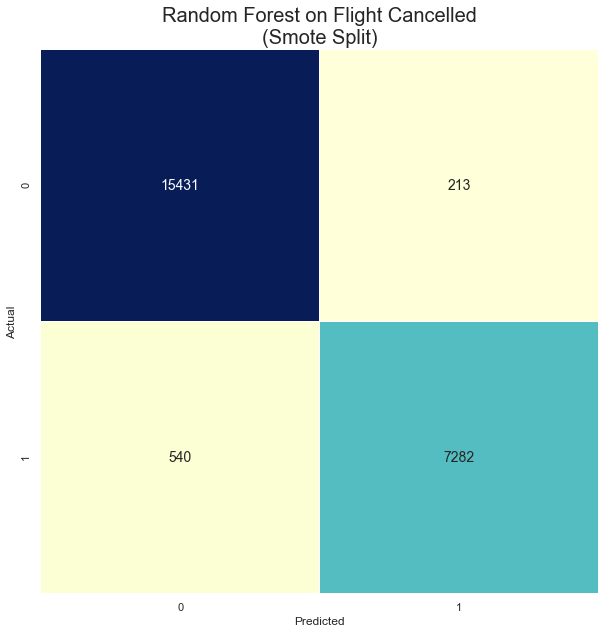

In [223]:
# Define confusion matrix
confusion = pd.crosstab(y_test_can_smote, y_pred_v2, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('Random Forest on Flight Cancelled\n(Smote Split)', fontsize = 20)

# Print scores
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_can_smote, y_pred_v2)))
print('Precision: {:.2f}'.format(precision_score(y_test_can_smote, y_pred_v2)))
print('Recall: {:.2f}'.format(recall_score(y_test_can_smote, y_pred_v2)))
print('F1-score: {:.2f}'.format(f1_score(y_test_can_smote, y_pred_v2)))

The corresponding confusion matrix for our random forest model shows where our classifier grouped each instance. The color coding is based on frequency - the higher the values, the darker the color. We want the top left and bottom right to be the darkest colors, as those are the groups that were classified correctly. From the above confusion matrix, our model correctly classified 15,431 non-cancellations out of 15,644 total actual non-cancellations. It also correctly classified 7,282 cancellations out of 7,822 total actual cancellations.


Accuracy: 0.93

Precision: 0.87
Recall: 0.94
F1-score: 0.90


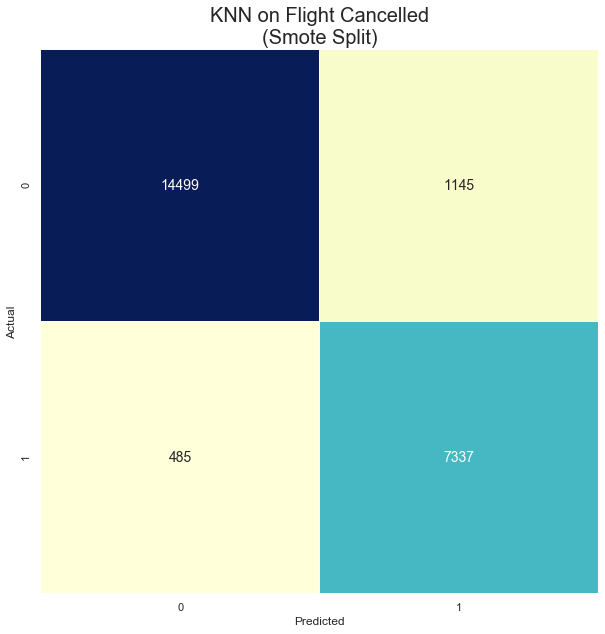

In [232]:
# Define confusion matrix
confusion = pd.crosstab(y_test_can_smote, y_pred_knn_v0, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('KNN on Flight Cancelled\n(Smote Split)', fontsize = 20)

# Print scores
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_can_smote, y_pred_knn_v0)))
print('Precision: {:.2f}'.format(precision_score(y_test_can_smote, y_pred_knn_v0)))
print('Recall: {:.2f}'.format(recall_score(y_test_can_smote, y_pred_knn_v0,)))
print('F1-score: {:.2f}'.format(f1_score(y_test_can_smote, y_pred_knn_v0)))

### 6.1.2 Undersampled Data


Accuracy: 0.89

Precision: 0.88
Recall: 0.79
F1-score: 0.83


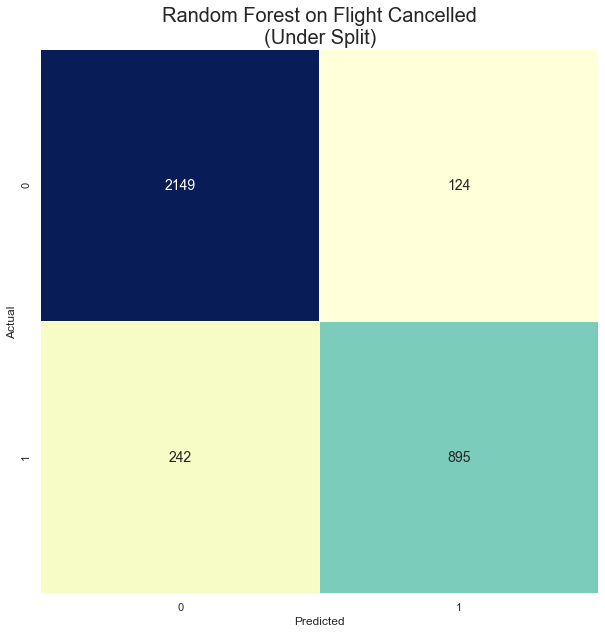

In [233]:
# Define confusion matrix
confusion = pd.crosstab(y_test_can_under, y_pred_v1, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('Random Forest on Flight Cancelled\n(Under Split)', fontsize = 20)

# Print scores
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_can_under, y_pred_v1)))
print('Precision: {:.2f}'.format(precision_score(y_test_can_under, y_pred_v1)))
print('Recall: {:.2f}'.format(recall_score(y_test_can_under, y_pred_v1)))
print('F1-score: {:.2f}'.format(f1_score(y_test_can_under, y_pred_v1)))


Accuracy: 0.72

Precision: 0.58
Recall: 0.54
F1-score: 0.56


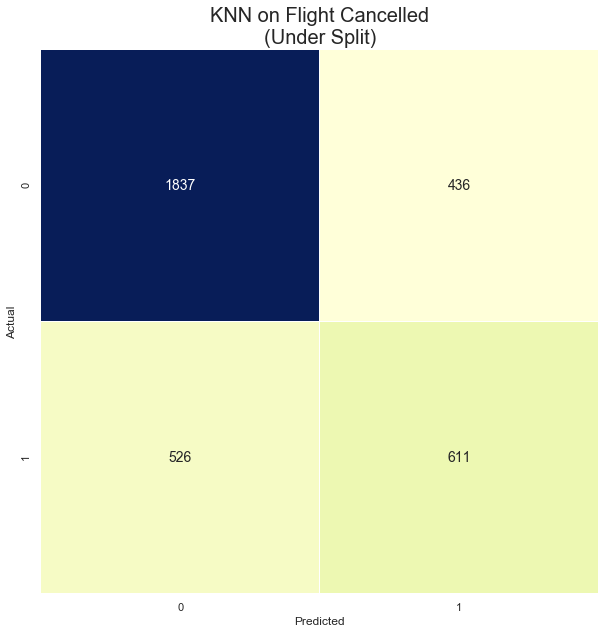

In [235]:
# Define confusion matrix
confusion = pd.crosstab(y_test_can_under, y_pred_knn_v1, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('KNN on Flight Cancelled\n(Under Split)', fontsize = 20)

# Print scores
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_can_under, y_pred_knn_v1)))
print('Precision: {:.2f}'.format(precision_score(y_test_can_under, y_pred_knn_v1)))
print('Recall: {:.2f}'.format(recall_score(y_test_can_under, y_pred_knn_v1)))
print('F1-score: {:.2f}'.format(f1_score(y_test_can_under, y_pred_knn_v1)))

### 6.2 Delay Data

In [ ]:
# Define confusion matrix
confusion = pd.crosstab(y_test_del, y_pred_del, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('Random Forest on Flight Delays\n(Original Split)', fontsize = 20)

# Print scores
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_del, y_pred_del)))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del, y_pred_del, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del, y_pred_del, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del, y_pred_del, average='weighted')))

In [ ]:
# Define confusion matrix
confusion = pd.crosstab(y_test_del_under, y_pred_del_under, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('Random Forest on Flight Delays\n(Undersample Split)', fontsize = 20)

# Print scores
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_del_under, y_pred_del_under)))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_under, y_pred_del_under, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_under, y_pred_del_under, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_under, y_pred_del_under, average='weighted')))


In [ ]:
# Define confusion matrix
confusion = pd.crosstab(y_test_del_smote, y_pred_del_smote, rownames = ['Actual'], colnames = ['Predicted'])

# Create confusion matrix using Seaborn
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(confusion, 
            annot = True, 
            cmap = "YlGnBu", 
            cbar = False,
            fmt = 'g',
            ax = ax,
            annot_kws = {'size' : 14},
           linewidths = 0.5)
ax.set_title('Random Forest on Flight Delays\n(Smote Split)', fontsize = 20)

# Print scores
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_del_smote, y_pred_del_smote)))
print('Weighted Precision: {:.2f}'.format(precision_score(y_test_del_smote, y_pred_del_smote, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_del_smote, y_pred_del_smote, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_del_smote, y_pred_del_smote, average='weighted')))


## 7. Modeling and Evaluation 5

> **[10 points]** Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.

### 7.1 Cancellation Data Model Comparison

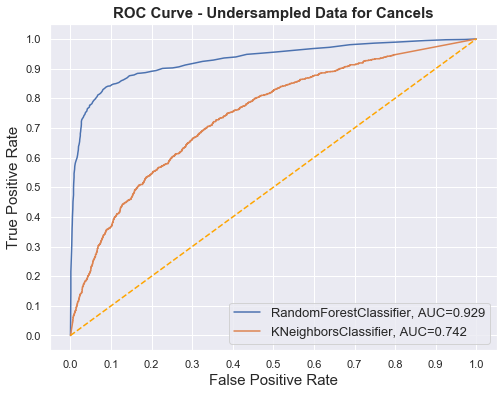

In [215]:
#ROC curve comparison - undersampled data
from sklearn.metrics import roc_curve, roc_auc_score

#adapted from https://abdalimran.github.io/2019-06-01/Drawing-multiple-ROC-Curves-in-a-single-plot

# Instantiate the classfiers and make a list
classifiers = [rf_v1, 
               knn_v1]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train_can_under, y_train_can_under)
    yproba = model.predict_proba(X_test_can_under)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test_can_under,  yproba)
    auc = roc_auc_score(y_test_can_under, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve - Undersampled Data for Cancels', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [228]:
# is clf1 better or worse than clf2? - for UNDERSAMPLED

#RF with undersampling
acc1_can = metrics.accuracy_score(y_test_can_under, y_pred_v1)
#KNN with undersampling
acc2_can = metrics.accuracy_score(y_test_can_under, y_pred_knn_v1)

#need to update t based on sample size - is it 2 for 2 splits?
t = 2.26 / np.sqrt(10)

e_can = (1-acc1_can)-(1-acc2_can)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot_can = np.std(e_can)

dbar_can = np.mean(e_can)
print ('Range of:', dbar_can-t*stdtot_can,dbar_can+t*stdtot_can )
print (np.mean(acc1_can), np.mean(acc2_can))

Range of: -0.17478005865102642 -0.17478005865102642
0.8926686217008798 0.7178885630498534


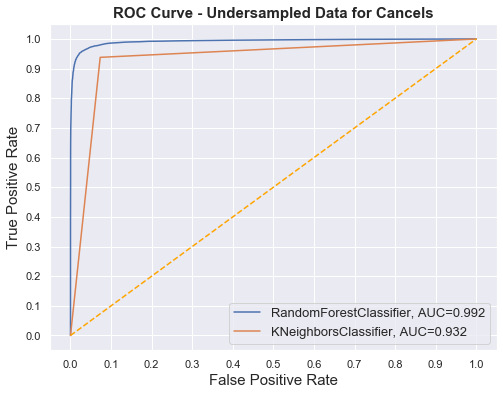

In [224]:
#ROC curve comparison - SMOTE data
# Instantiate the classfiers and make a list
classifiers = [rf_v2, 
               knn_v0]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train_can_smote, y_train_can_smote)
    yproba = model.predict_proba(X_test_can_smote)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test_can_smote,  yproba)
    auc = roc_auc_score(y_test_can_smote, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve - Undersampled Data for Cancels', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [227]:
# is clf1 better or worse than clf2? - FOR SMOTE

#RF with smote
acc1_can = metrics.accuracy_score(y_test_can_smote, y_pred_v2)
#KNN with smote
acc2_can = metrics.accuracy_score(y_test_can_smote, y_pred_knn_v0)

#need to update t based on sample size - is it 2 for 2 splits?
t = 2.26 / np.sqrt(10)

e_can = (1-acc1_can)-(1-acc2_can)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot_can = np.std(e_can)

dbar_can = np.mean(e_can)
print ('Range of:', dbar_can-t*stdtot_can,dbar_can+t*stdtot_can )
print (np.mean(acc1_can), np.mean(acc2_can))

Range of: -0.03737322083013728 -0.03737322083013728
0.9679110201994375 0.9305377993693003


** write up here on model comparison for cancels

### 7.1 Delay Data Model Comparison

Insert ROC curves and 95% CI here

# 8. Modeling and Evaluation 6

> **[10 points]** Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

Insert feature importance for both RF models of delays and cancels

In [230]:
#feature important for RF on SMOTE data

features_can = df_cancel.iloc[:,:-1]

feature_imp = pd.Series(rf_v2.feature_importances_,index=features_can.columns).sort_values(ascending=False)
#show top 5
feature_imp[0:5]

weather_id             0.148584
weather_main_Clouds    0.089490
clouds_all             0.082767
temp                   0.058197
MONTH                  0.044820
dtype: float64

In [240]:
#feature important for RF on SMOTE data - delays

features_del = df_delay.iloc[:,:-1]

feature_imp_del = pd.Series(rf.feature_importances_,index=features_del.columns).sort_values(ascending=False)
#show top 5
feature_imp_del

ORIGIN_AIRPORT_DFW                0.0
AIRLINE_CODE_F9                   0.0
AIRLINE_CODE_DL                   0.0
AIRLINE_CODE_B6                   0.0
AIRLINE_CODE_AS                   0.0
TAIL_NUMBER_encode                0.0
DESTINATION_AIRPORT_encode        0.0
weather_id                        0.0
clouds_all                        0.0
snow_3h                           0.0
snow_1h                           0.0
rain_3h                           0.0
rain_1h                           0.0
wind_deg                          0.0
wind_speed                        0.0
humidity                          0.0
pressure                          0.0
temp                              0.0
SCHEDULED_TIME                    0.0
TAXI_OUT                          0.0
FLIGHT_NUMBER                     0.0
DAY_OF_WEEK                       0.0
DAY                               0.0
AIRLINE_CODE_EV                   0.0
AIRLINE_CODE_MQ                   0.0
weather_main_Thunderstorm         0.0
AIRLINE_CODE

# 9. Deployment

> **[5 points]** How useful is your model for interested parties (i.e., the companies or
organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

The work that we did as part of this lab would be very useful for both airlines as well as airport management at Dallas Fort Worth International Airport (DFW) and Dallas Love Field (DAL). For the airlines, being able to better predict departure delays and cancellations could lead to better customer service for passengers. For airport management, having a better understanding of when a cancellation or delay may occur would allow them to better direct airport resources when it comes to terminals, gates, runways, and staffing.

If we were to deploy this model, we envision a stoplight system of green, yellow, and red indicators for whether a flight is likely to be delayed or cancelled. A color-coded system conveys the information in a way that doesn’t mislead the user the same way that seeing a numeric value, like a percentage, would. 

A measure of the model’s value would be the acceptance and usage of the various stakeholders. If it is not performing well, adoption will suffer and lead to distrust and future usage.

# 10. Exceptional Work

> - You have free reign to provide additional modeling.
> - One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?

Add comments on grid search and adding the weather data